*You may navigate the notebook through the table of contents on the left.*

---
# **Dimensionality reduction for neural data**
---

Leonardo Agueci <sup>1</sup>, Arthur Pellegrino<sup>2</sup> and N. Alex Cayco Gajic<sup>1</sup>

<sup>1</sup>Ecole Normale Superieure, <sup>2</sup>University of Edinburgh

# Introduction

<p align="center" width="100%">
<img src="https://drive.google.com/uc?id=1bWAEsI-pGOSUWmMW3TfSmTVk1B32jSkR" width="550px;">
</p>

In this tutorial you will extensively learn about principal component analysis (PCA) [1,2] and its application on neural data. 
- In __Part I__, we introduce you to the theory underlying this dimensionality reduction method, and its relationship with singular value decomposition (SVD). Then, we will extend its usage to tensors, basic step for applying this method to standard neural data; as a ___bonus___, you will find a brief introduction to tensor component analysis (TCA) and to sliceTCA. Finally, you will find a description of the bi-cross validation method. 
- In __Part II__ you will use this theoretical background to implement PCA.
- __Part III__ focuses on how to cross-validate the number of components.
- In __Part IV__ you will apply PCA to neural data recorded during hand movement.
- Finally, __Part V__ we will finally try to gain some understanding of what could be encoded in our neural recordings using some simple linear decoders

___Remarks:___ 
- Code cells are partially filled sometimes, for helping you with coding and visualization. Although you can change any part of the code as you prefer (e.g. for improving visualization), we recommend to add you code only in the parts delimited as follows:

```(python)

# Fill in your code below
###########################

# Instruction 1 
# your code

# Instruction 2
# your code

###########################
```

# **Part I.** The theory behind (multi)linear dimensionality reduction

One of the reasons for the enduring popularity of PCA is its analytical interpretability. To demonstrate this, we will present two mathematically equivalent formulations of PCA: 1) identifying the directions of maximum projected variance, and 2) finding the best low-dimensional approximation to the data matrix. By setting up these two questions as constrained optimization problems (following [2]), it can be shown that the two formulations yield the same solution: the eigenvalues and eigenvectors of the data covariance matrix. We will then cover the relationship between PCA and singular value decomposition (SVD), and the Eckart-Young Theorem which guarantees that the SVD is the closest low-rank approximation to the data matrix. The equivalence of these two formulations (the closest low rank approximation and vs directions of maximum variance) will set up the intuition necessary to understand data tensor extensions such as TCA or sliceTCA.

## The equivalent formulations of PCA

### PCA as the directions of maximum projected variance

When discussing PCA, we follow convention that we are working with a data matrix $\mathbf{X} \in \mathbb{R}^{N \times K}$ where $N$ is the number of neurons and $K$ the number of samples. We further assume that the data has already been centered, that is the activity of each neuron has been subtracted its mean. The sample covariance matrix $\mathbf{\hat\Sigma}\in \mathbb{R}^{N \times N}$ is then defined as $\mathbf{\hat \Sigma} = \frac{1}{N_\text{samples}}\mathbf{X}\mathbf{X}^T$.

We start by seeking the vector $\mathbf{u} \in \mathbb{R}^N$ that maximizes the variance of the projected data. We further add the constraint that $\bf u$ must be normalized ($\mathbf{u}^T\mathbf{u}=1$, else the problem is unbounded). Then, the projected data is simply $\mathbf{u}^T\mathbf{X}\in \mathbb{R}^{K}$. The projected variance is then given by:

\begin{align}
\text{var}(\mathbf{u}^T\mathbf{X}) =& \frac{1}{N_\text{samples}}(\mathbf{u}^T \mathbf{X})(\mathbf{X}^T \mathbf{u}) \\
=&\mathbf{u}^T \left ( \frac{1}{N_\text{samples}}\mathbf{X}\mathbf{X}^T \right ) \mathbf{u} \\
=& \mathbf{u}^T \mathbf{\hat \Sigma} \mathbf{u}.
\end{align}

One way to solve such an optimization problem is to use [Lagrange multipliers](https://en.wikipedia.org/wiki/Lagrange_multiplier). First, we define the Lagrange function:

$$ L(\mathbf{u},\lambda) = \mathbf{u}^T \mathbf{\hat \Sigma u} + \lambda(1-\mathbf{u}^T\mathbf{u})$$

A necessary condition for $\mathbf{u}$ to be a maximum under the imposed constraint is that it must be a zero of the gradient of the Lagrange function:

$$ \nabla_{\mathbf u} L = \mathbf{\hat \Sigma u} - \lambda \mathbf{u} = 0 $$

That is, $ \mathbf{\hat \Sigma u} = \lambda \mathbf{u}$, therefore  $\mathbf{u}$ must be an eigenvector of the data covariance matrix and $\lambda$ its corresponding eigenvalue. Combining this with the projected variance as derived above, we get $\text{var}(\mathbf{u}^T\mathbf{X}) = \mathbf{u}^T \mathbf{\hat \Sigma} \mathbf{u} = \lambda\mathbf{u}^T  \mathbf{u} = \lambda$. Therefore the vector that maximizes the projected variance is the eigenvector of $\bf \hat \Sigma$ with the largest eigenvalue.

We can show inductively that by repeating this argument (with an additional constraint that each vector is orthogonal to the previously identified vectors), that the directions of maximum projected variance are given by the eigenvectors of $\bf \hat \Sigma$ and the projected variances by their corresponding eigenvalues.

The first $R$ principal components are given by projecting the data $\bf X$ onto the $R$ eigenvectors of the covariance matrix with largest eigenvalues. The eigenvectors are often called the loadings or weights, and the projected data are often called the scores.

Finally, we note that since $\bf \hat \Sigma$ is symmetric, its eigenvectors form an orthonormal basis for $\mathbb{R}^N$. In the context of PCA, this means that the loading vectors are orthogonal and the scores are uncorrelated.

### PCA as the low-dimensional projection that minimizes reconstruction error

In this second formulation we will attempt to find the low-dimensional projection of $\mathbf{X}$ with the smallest *reconstruction error*. We'll denote each sample (i.e. column) of the data matrix as ${\bf x}_n\in\mathbb{R}^N$. We thus seek an $R$-dimensional subspace such that, on average over all samples, the data projected on this subspace $\mathbf{\hat x}_n\in\mathbb{R}^N$ is closest to ${\bf x}_n$. We'll call our candidate orthonormal basis $\mathbf{u}_1,\dots,\mathbf{u}_R\in\mathbb{R}^N$, which spans this $R$-dimensional subspace within the $N$-dimensional activity space. Then, the estimate of each sample can be written as the linear combination:

$${\bf \hat x}_n =\sum_{i=1}^R \beta_{ni} \mathbf{u}_i$$

for some coefficients $\beta_{ni}$, which we would like to find as a function of $\mathbf{u}_i$ and $\mathbf{x}_n$.

Note that we're still missing $N-R$ vectors needed to form a complete orthonormal basis for the full activity space: we'll simply call such vectors $\mathbf{u}_{R+1},\dots,\mathbf{u}_N$. This means that we can rewrite each sample as:

$${\bf x}_n =\sum_{i=1}^N \alpha_{ni} \mathbf{u}_i$$

Since the $\mathbf{u}_i$'s are orthonormal, the coefficients are simply given by the projections of the data onto each basis vector: $\alpha_{ni} =\mathbf{x}_n^T \mathbf{u}_{i} $. You can verify this by taking the dot product of the above equation with $\mathbf{u}_j$ (remembering that $\mathbf{u}_i$'s being orthonormal is defined as: $\mathbf{u}_i\cdot \mathbf{u}_j=1$ if $i=j$ else $0$).

We can write the mean-squared error as:
$$ E =  \frac{1}{N \cdot N_\text{samples}} \sum_{n=1}^{N_\text{samples}} \lVert \mathbf{x}_n - \mathbf{\hat x}_n \rVert^2 $$
First, using our expressions for the samples above, we can write the residual on the right as:

\begin{align}
 \mathbf{x}_n - \mathbf{\hat x}_n = \sum_{i=1}^R (\alpha_{ni}-\beta_{ni})\mathbf{u}_i + \sum_{j=R+1}^N \alpha_{nj}\mathbf{u}_j
\end{align}

Now, noting that $\lVert \mathbf{x}_n - \mathbf{\hat x}_n \rVert^2 = ( \mathbf{x}_n - \mathbf{\hat x}_n )\cdot  (\mathbf{x}_n - \mathbf{\hat x}_n)$, and using the fact that the $\mathbf{u}_i$'s are orthonormal, the norm of the residual can be simplified as:

\begin{align}
\lVert \mathbf{x}_n - \mathbf{\hat x}_n \rVert^2 = \sum_{i=1}^R (\alpha_{ni}-\beta_{ni})^2 + \sum_{j=R+1}^N \alpha_{nj}^2
\end{align}

Finally, we can minimize the error by differentiating it as:
$$\frac{d E}{d \beta_{ni}} =  \frac{2}{N \cdot N_\text{samples}} (\beta_{ni} - \alpha_{ni})$$

which means that the $\beta_{ni}$ that minimizes the MSE is given simply by $\beta_{ni} = \alpha_{ni} = \mathbf{x}_n^T \mathbf{u}_i$. In retrospect this makes sense since the error should be minimized by projecting the data onto the low-dimensional subspace. We can now expand the error as:

\begin{align}
E =& \frac{1}{N \cdot N_\text{samples}} \sum_{n=1}^{N_\text{samples}} \sum_{j=R+1}^N \alpha_{nj}^2 \\
=& \frac{1}{N \cdot N_\text{samples}} \sum_{n=1}^{N_\text{samples}} \sum_{j=R+1}^N (\mathbf{x}_n^T \mathbf{u}_j)^2 \\
=& \frac{1}{N \cdot N_\text{samples}} \sum_{n=1}^{N_\text{samples}} \sum_{j=R+1}^N (\mathbf{u}_j^T\mathbf{x}_n )(\mathbf{x}_n^T \mathbf{u}_j) \\
=& \frac{1}{N} \sum_{j=R+1}^N \mathbf{u}_j^T \mathbf{\hat \Sigma u}_j
\end{align}
Where last step follows from $\mathbf{x}_n$ being mean-centered. It now remains to find an orthonormal basis $\mathbf{u}_j$ that minimizes the mean squared error. In the case that $R=N-1$, we have the same Lagrangian as before (up to a scaling factor):
$$ L(\mathbf{u},\lambda) = \frac{1}{N} \mathbf{u}^T \mathbf{\hat \Sigma u} + \lambda(1-\mathbf{u}^T\mathbf{u})$$
Again the solutions are the eigenvectors of the covariance matrix. This time, since we want to *minimize* the reconstruction error, we choose the eigenvector with smallest eigenvalue for the residual, which means that the low-dimensional subspace we project the data on is spanned by the remaining eigenvectors with larger eigenvalues.

*In general,* it can be shown that taking the $R$ largest eivenvectors of the covariance matrix as the principal subspace solves the constrained minimization of the MSE, resulting in the same solution as in the previous section. *Therefore,* PCA can be formulated in two mathematically equivalent forms: maximizing the directions of projected variance, or minimizing the reconstruction error of a low-dimensional projection.


### PCA as a low-rank approximation to the data matrix

So far we saw PCA as solving two different constrained optimization problems by projecting of the data onto the eigenvectors of the covariance matrix. Further, since the covariance matrix has an orthonormal set of eigenvectors, this projection can be considered as a change of basis from Cartesian coordinates (i.e., each dimension represents a different neuron) to a more "natural" basis of the data (i.e., each dimension represents a different covariability pattern across the population). Mathematically this projection is given by the equation:
$$ \mathbf{Z} = \mathbf{U}^T \mathbf{X}$$
where $\bf U \in \mathbb{R}^{N\times N}$ is a matrix whose columns are given by the orthonormal eigenvectors of $\mathbf{\hat \Sigma}$, in order of descending eigenvalue magnitude (which is the variance of the projected data, therefore this ranks the components by how much variance of the data they capture).

Note that since its columns $\mathbf{u}_i$ are orthonormal, $\bf U$ is a unitary matrix. An important property of unitary matrices is that $\mathbf{U}^{-1} = \mathbf{U}^T$. To see this, note that the $\mathbf{U}^T \mathbf{U} = \mathbf{I}$ falls out naturally from matrix multiplication, as $(\mathbf{U}^T \mathbf{U})_{ij}=\mathbf{u}_i^T\mathbf{u}_j = \delta_{ij}$ by orthonormality. To prove that $ \mathbf{U} \mathbf{U}^T = \mathbf{I}$, we can multiply both sides of the equation above by $\mathbf{U}$ on the left and $\mathbf{U}^{-1}$ on the right as follows:
\begin{align}
\mathbf{U}^T \mathbf{U} &= \mathbf{I} \\
\mathbf{U}(\mathbf{U}^T \mathbf{U})\mathbf{U}^{-1} &= \mathbf{U}\mathbf{U}^{-1}\\
\mathbf{U}\mathbf{U}^T &= \mathbf{I} \\
\end{align}

This is important in the context of PCA because it means we can easily move $\mathbf{U}$ to the other side of the equation to project the scores back into the original basis, returning the original data matrix:
$$\mathbf{U} \mathbf{Z} = \mathbf{X}$$
and now we see that PCA is a *matrix decomposition*, meaning that it decomposes the data matrix into a product of two matrices: the new basis vectors (or loadings) $\bf U$ and the projected data (or scores) $\mathbf Z$.

In dimensionality reduction, the purpose is to reduce the number of features used to capture the data. In PCA, this is done by taking the first $R$ components, which correspond to the largest eigenvalues (and thus the directions of largest projected variance). To do this we simply truncate the projection matrix after the first $R$ columns to get $\mathbf{ U }_{R}\in \mathbb{R}^{N\times R}$. Then the $R$-dimensional scores are still given by the same formula:
$$ \mathbf{Z}_R = \mathbf{U}_{R}^T \mathbf{X}$$

However we cannot simply move $\mathbf{U}_{R}$ to the other side of the equation. While we still have $\mathbf{U}_{R}^T  \mathbf{U}_{R} = \mathbf{I}$ (due to orthonormality of the columns), we can no longer guarantee that $ \mathbf{U}_{R} \mathbf{U}_{R}^T  = \mathbf{I}$ since our proof above relied on the existence of $\mathbf{U}_{R}^{-1}$, which does not exist for non-square matrices ($R< N$)! Geometrically, this makes sense since we can project from a high-dimensional space to a low-dimensional space but cannot invert the projection to recover the exact original data.

We can try to revert the transformation anyway by projecting the top $R$ components back into the $N$-dimensional space using $\mathbf{U}_R$. This results in the following *approximation* to the data matrix:
$$ \mathbf{ \hat X} = \mathbf{U}_{R} \mathbf{Z}_R$$
Another way to write this approxmination is to expand it as a sum of the outer products of the column.
$$ \mathbf{ \hat X} = \sum_{r=1}^R \mathbf{u}_{r} \mathbf{ z}^T_r$$
where $ \mathbf{u}_{r}$ are the columns of $ \mathbf{U}$ and $ \mathbf{ z}^T_r$ are the rows of $\mathbf{Z}$. Each column of $\mathbf{\hat X}$ is a linear combination of the $R$ basis vectors, so the rank of $ \mathbf{ \hat X} $ is (at most) $R$. Equivalently, the approximated data will lie on an $R$-dimensional subspace of $\mathbb{R}^N$ spanned by the new basis $\mathbf{u}_1,\dots,\mathbf{u}_R$.

This brings us back to the low-dimensional projection view that we saw previously, which further suggests that it may be the best low-rank approximation of the data matrix. This is indeed the case, as we will see in the next section.


### Relationship between PCA and SVD

PCA is very closely related to a more general matrix decomposition called the singular value decomposition (SVD). It is an amazing fact that any rank-$R$ matrix can be decomposed into three matrices:
$$ {\mathbf X} = {\mathbf U S} \mathbf{V}^T$$
where ${\mathbf U} \in \mathbb{R}^{N \times R}$ and $\mathbf{V} \in \mathbb{R}^{K \times R}$ have orthonormal columns (called the left and right singular vectors, respectively) that define new rotated bases for their respective vector spaces, and $\mathbf{S}\in \mathbb{R}^{R \times R}$ is a positive diagonal matrix (whose diagonal elements $\sigma_i$ are called the singular values, and are ranked in decreasing order). Most often, you will equivalently find it defined with, $U\in\mathbb{R}^{N\times \min\{N,K\}}$, $S\in\mathbb{R}^{\min \{N,K\}\times \min\{N,K\}}$, $V\in\mathbb{R}^{\min\{N,K\}\times N}$, in which case the rank of $\bf X$ is simply the number of non-zero singular values. The SVD can be thought of as decomposing a matrix into how it operates on vectors: by taking a $K$-dimensional vector, rotating it into a new basis, shrinking or stretching the new coordinates according to $\sigma_i$, and projecting it into $\mathbb{R}^N$.

How does this relate to PCA? To see this, let's again assume that $\mathbf{X}$ is mean-centered and calculate the covariance matrix using the SVD:
\begin{align}
\mathbf{\hat \Sigma} =& \frac{1}{N_\text{samples}}\mathbf{X}\mathbf{X}^T \\
=& \frac{1}{N_\text{samples}}\mathbf{USV}^T\mathbf{VSU}^T \\
=& \frac{1}{N_\text{samples}}\mathbf{US}^2\mathbf{U}^T \\
\end{align}
which is an eigenvalue decomposition of the covariance matrix (up to the scaling). Therefore the transformed basis vectors ${\mathbf U}$ in SVD and PCA are identical, and the eigenvalues and singular values are related as $\lambda_i = \sigma_i^2/N_\text{samples}$. Consistent with the previous definitions, the scores in PCA are given by $\mathbf{Z=U}^T\mathbf{X=U}^T\mathbf{USV}^T=\mathbf{SV}^T$. Therefore, in the language of SVD, dimensionality reduction with PCA is equivalent to truncating the decomposition after $R$ singular values. This means taking only the first $R$ columns of ${\mathbf U}$ and ${\mathbf V}$ as well as the upper $R\times R$ corner of $\mathbf S$ to get the following rank-$R$ approximation:
$$ \mathbf{\hat X} = \mathbf {U}_R \mathbf{S}_{R} \mathbf{V}_R^T$$

Further, the [Eckart-Young Theorem](https://rich-d-wilkinson.github.io/MATH3030/3-5-lowrank.html) states that the truncated SVD approximation above gives the rank-$R$ that is closest to the data matrix in the Frobenius norm:
$$\min_{\text{rank}(\mathbf{Y}) \leq R} \lVert  \mathbf{X - Y} \rVert_F$$
with $\lVert  \mathbf{X - \hat X} \rVert_F = \left(\sum_{i=R+1}^N \sigma_i^2\right)^\frac{1}{2}$. Equivalently, this means that taking the top $R$ principal components PCA results in the best low-rank approximation to the data with the following MSE:
$$E = \frac{1}{N \cdot N_\text{samples}}\sum_{i=R+1}^{N}\sigma_i^2 $$

Together with the maths demonstrated above, this shows that there is a deep connection between minimizing the error of a low rank (or low-dimensional) approximation and capturing covariability patterns in neural data. In the following section we will discuss this idea in extension to neural data tensors.

## From matrices to tensors

So far, we have focused on reducing the dimensionality of a matrix $\mathbf{X}\in \mathbb{R}^{N \times K}$. However, in neuroscience we often work with a data *tensor* $\mathcal{X}\in \mathbb{R}^{N \times T \times K}$, where $N$ is the number of neurons, $K$ the number of *trials* and $T$ the number of time points.

The first key element to notice, is that, unlike for matrices, we cannot naturally separate the variables at hand into *features* (neurons) and *samples* (time points). Instead there are two relevant notions of sampling (across time points and across trials) which we would like to keep separated to interpret the data [4]. In the following sections, we will look at three complementary ways to account for this, from which stem three dimensionality reduction methods : PCA on unfoldings [3], TCA [4] and sliceTCA [5].

### PCA on unfoldings

#### Neuron-unfolding

The first strategy, is to go back to the matrix case by *unfolding* the data tensor. For example, if we wish to keep neurons as features, we can unfold the tensor $\mathcal{X}\in \mathbb{R}^{N \times T \times K}$ into a matrix $\mathbf{X}\in \mathbb{R}^{N\times (TK)}$. If we now apply the low-rank approximation perspective on PCA to this matrix, the data can be approximated as:

$$
  \mathbf{X}\approx \mathbf{\hat X} = \mathbf{U}\mathbf{Z} \in \mathbb{R}^{N\times (TK)}
$$

where $\mathbf{U}\in\mathbb{R}^{N\times R}$ and $\mathbf{Z}\in \mathbb{R}^{R \times(TK)}$. As seen previously, this can be equivalently written as the sum of the following outer products:

$$
\mathbf{\hat X} = \sum_{r=1}^R \mathbf{u}_r\mathbf{z}^T_r
$$

where $\mathbf{u}_r \in \mathbb{R}^N$ are the columns of $\bf U$ and $\mathbf{z}_r\in\mathbb{R}^{TK}$ are the rows of $\bf V$.


Next, we can *fold* each $\mathbf{z}_r$ back into a matrix $\mathbf{W}_r\in\mathbb{R}^{T \times K}$. The outer product $\mathbf{u}_r\mathbf{z}^T_r$ is sometimes written in the form $\mathbf{u}_r\otimes \mathbf{z}_r$, which allows us to generalize the notation for the outer product of two vectors $(\mathbf{u}_r\otimes \mathbf{z}_r)_{ij}=\mathbf{u}_{r,i}\mathbf{z}_{r,j}$  to the outer product of a vector with a matrix $(\mathbf{u}_r\otimes \mathbf{W}_r)_{ijk}=\mathbf{u}_{r,i}\mathbf{W}_{r,jk}$. The figure below shows how a single *component* can be seen as either the outer product of a vector with a matrix or with a (long) vector.

<p align="center" width="100%">
<img src="https://drive.google.com/uc?id=1oxa02j3jDSrY2izD9M_bpoHtWa6Ja6I1" width="500px;">
</p>

This way, we can rewrite our (SVD/PCA) approximation directly as a tensor:

$$
\mathcal{X} \approx \mathcal{\hat X} = \sum_{r=1}^R \mathbf{u}_r \otimes \mathbf{W}_r \in \mathbb{R}^{N \times T \times K}
$$

And, since the Frobenius norm is defined element-wise, the same objective as for the matrix case can be used to determine the decomposition:

$$
E(\mathbf{u}_1,..., \mathbf{u}_r, \mathbf{W}_1, ..., \mathbf{W}_r) = \lVert \mathcal{X} - \mathcal{\hat X} \rVert_F
$$

#### Trial-unfolding

We arbitrarily decided that the *neuron* leg would be the features (the $\mathbf{u}$'s). When working with matrices, this doesn't matter; in the end, the term $\mathbf{u}_r \mathbf{z}_r^T$ is symmetric, in the sense that it can be transposed (i.e. swap $\mathbf{u}_r$ and $\mathbf{z}_r$) to now consider the time points as features. When moving to tensors, this doesn't work anymore, as $\mathbf{z}_r$ now represents two variables (e.g. time and trial).

In the context of tensors, if we consider *time* as our features, we just have to unfold the tensor along another of its *legs*:

<p align="center" width="100%">
<img src="https://drive.google.com/uc?id=1dHfvXK4ay3gZHx2_Om35MiRgWrOcNIDY" width="500px;">
</p>

And similarly for trials [3]:

<p align="center" width="100%">
<img src="https://drive.google.com/uc?id=1AOPTNowx6LejxaGaMJGjqD58_KEBJcvE" width="500px;">
</p>

To keep track of the different vectors and matrices at hand, we can indicate the leg(s) of the tensor they describe as a supsercript. For trial-unfolding PCA, we would therefore write:

$$
\mathcal{X} \approx \mathcal{\hat X} = \sum_{r=1}^R \mathbf{u}_r^{trial} \otimes \mathbf{W}^{neuron, time}_r
$$

Note that, formally, $\mathbf{u}_r^{trial} \otimes \mathbf{W}^{neuron, time}_r \in \mathbb{R}^{K \times N \times T}$, but we have implicitely permuted the indices to match the data tensor in $\mathbb{R}^{N \times T \times K}$.

### (bonus) SliceTCA

We have just seen that applying PCA on unfoldings of a data tensor was equivalent to writing the approximation of the data tensor as a sum of outer product of vectors (the feature) and matrices (the folded scores vectors). We can generalize this concept by allowing different types of unfoldings within the same sum. Preserving the same notation as before,

$$
\mathcal{X} \approx \mathcal{\hat X} = \sum_{r=1}^{R_{neuron}} \mathbf{u}_r^{neuron} \otimes \mathbf{W}^{time, trial}_r  + \sum_{r=1}^{R_{time}} \mathbf{u}_r^{time} \otimes \mathbf{W}^{neuron, trial}_r  + \sum_{r=1}^{R_{trial}} \mathbf{u}_r^{trial} \otimes \mathbf{W}^{neuron, time}_r
$$

This decomposition is called sliceTCA [5].

<p align="center" width="100%">
<img src="https://drive.google.com/uc?id=1H5RkoRhITPLbAGHiLMKaK_WsQqk-WzfM" width="600px;">
</p>

Note that by setting (e.g.) $R_{time}=R_{trial} = 0$, we fall back onto (e.g.) the neuron-unfolding PCA decomposition. So that sliceTCA is a generalization (or in a set-theoretic sense, a superclass) of PCA on unfoldings.

### (bonus) TCA

Another strategy for going from PCA on unfoldings to a tensor decomposition is to constrain the slices to be of rank $1$. Consider again a PCA on (any) unfolding decomposition:

$$
\mathcal{X} \approx \mathcal{\hat X} = \sum_{r=1}^R \mathbf{u}_r \otimes \mathbf{W}_r \in \mathbb{R}^{N \times T \times K}
$$

If we now constrain the matrix to be of rank $1$, that is $\mathbf{W}_r = \mathbf{v}_r \mathbf{w}_r^T = \mathbf{v}_r \otimes \mathbf{w}_r$:

<p align="center" width="100%">
<img src="https://drive.google.com/uc?id=1STP28EUzPHYZNEkh0uC0PiUPmf4W1fx5" width="500px;">
</p>

And we thus obtain the decomposition:

$$
\mathcal{X} \approx \mathcal{\hat X} = \sum_{r=1}^R \mathbf{u}_r \otimes \mathbf{v}_r \otimes \mathbf{w}_r \in \mathbb{R}^{N \times T \times K}
$$

This decomposition is known within neuroscience as tensor component analysis (TCA, [4]) but in other fields (such as physics) is known by other names: CANDECOMP, PARAFAC, or simply the CP decomposition. Therefore, PCA is a generalization (or superclass) of TCA.

### Relationship between tensor decomposition methods

Overall, the relationsip between the three tensor decomposition methods presented here can be summarized by the following Venn diagram [5]:

<p align="center" width="100%">
<img src="https://drive.google.com/uc?id=1mNdFEP7gnDK72Q-jDyT1jkKs1sG4q698" width="300px;">
</p>


# **Part II.** Implementing on toy data

To familiarize yourselves with PCA/SVD, you will first write your own implementation of PCA (without using `sklearn`). Second, you will try to *guess* the rank of some simulated data using the bi-cross-validation method.

**WARNING:** In the maths above we used the convention that $\mathbf{X} \in \mathbb{R}^{N\times K} $ (i.e., the columns are the samples), as this is commonly used in neuroscience and in the PCA literature. However, other communities (notably in machine learning) use the rows as samples instead: $\mathbf{X} \in \mathbb{R}^{K\times N}$. Be mindful when you write your code that the packages you use may be using the latter notation (for example, in that case, the $\bf V$ in the SVD will represent the basis vectors, rather than the $\bf U$.).

First, execute the cell below to get started.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Vizualizing and denoising data with PCA

Here you will consolidate your understanding of PCA by implementing it on toy firing rate data.

First run the cell below to generate your data matrix $M$ of 10 neurons and 101 time points.

In [2]:
np.random.seed(3)

def exp_quad(x, l=0.1, s=1): 
    return np.exp(-x**2/(2*l**2))*s**2

n = 10
k = np.random.randint(1, n//2+1)
time_steps = 101
ts = np.linspace(0, 1, time_steps)
noise = 0.01
kernel = exp_quad

latent_gaussian = np.random.randn(time_steps, k)
covariance_matrix = kernel(np.subtract.outer(ts, ts))
L = np.linalg.cholesky(covariance_matrix+10**-6*np.eye(time_steps))

neuron_basis = np.random.randn(n, k)
time_basis = L @ latent_gaussian

M = time_basis @ neuron_basis.T + np.random.randn(n) + np.random.randn(time_steps, n)/3

print('Data matrix M (sample_size, neuron):', M.shape)

Data matrix M (sample_size, neuron): (101, 10)


**Step 1.** The first step of neural dimensionality reduction is *always* to look at the raw data first. Plot the single neuron activity generated by the previous code cell over time.

In [ ]:
# Fill in your code below

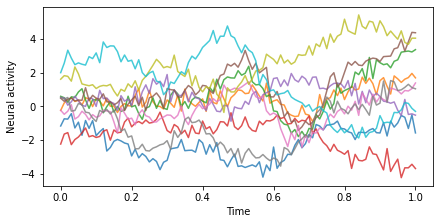

In [3]:
# Solution
fig = plt.figure(figsize=(6,3), constrained_layout=True)
ax = fig.add_subplot()

ax.plot(ts, M, alpha=0.8)
ax.set_xlabel('Time')
ax.set_ylabel('Neural activity')
plt.show()

**Step 2.** Center the data matrix (subtract from each neuron its mean activity). Make a scatter plot of two arbitrarily chosen neurons, using each as one of the two dimensions. What do you notice?

In [ ]:
fig = plt.figure(figsize=(4,4), constrained_layout=True)
ax = fig.add_subplot()

# Fill in your code below
###########################

# Center each neuron activity in M
M_centered = # your code here

# Plot the centered activity for neurons i and j of your choise
ax.scatter()

###########################

ax.set_aspect('equal')
ax.spines[['left', 'bottom']].set_position(("data", 0))
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Neuron '+str(i), loc='right')
ax.set_ylabel('Neuron '+str(j), loc='top')
plt.show()

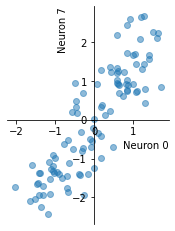

In [7]:
# Solution

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()

# Center each neuron activity
M_centered = M-M.mean(axis=0)

# Plot the centered activity for neurons i and j of your choice
i, j = 0, 7
ax.scatter(M_centered[:, i], M_centered[:, j], alpha=0.5)

ax.set_aspect('equal')
ax.spines[['left', 'bottom']].set_position(("data", 0))
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Neuron '+str(i), loc='right')
ax.set_ylabel('Neuron '+str(j), loc='top')
plt.show()

**Step 3.** Perform PCA using ``` np.linalg.svd ```.  Be careful with rows and columns, and verify whether the basis vectors should be $\bf U$ or $\bf V$. Make the following two plots:
* a scatter plot of projections of the data onto the first two PCs using the $S$, $V$, and $U$.
* a plot showing how the projected variance decays as a function of the number of components.

In [10]:
U, S, V = np.linalg.svd(M_centered, full_matrices=False)


(10, 101)

In [ ]:
# Fill in your code below
###############################

# Generate U, S, V using SVD
U, S, V = # your code here

# Generate the projected data
projection = # your code here

# Compute the variance along each dimension (careful with matrix axes!)
projected_variance = # your code here

###############################

fig = plt.figure(figsize=(8,3), constrained_layout=True)
ax = fig.add_subplot(1,2,1)

ax.scatter(projection[:,0], projection[:,1], alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax = fig.add_subplot(1,2,2)
ax.plot(projected_variance,'o-')
ax.set_xlabel('Number of components')
ax.set_ylabel('Projected variance')
plt.show()

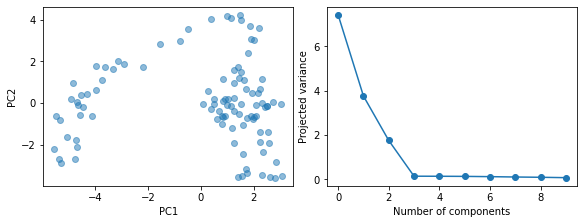

In [18]:
# Solution

# Generate U, S, V using SVD
U, S, V = np.linalg.svd(M_centered, full_matrices=False)

# Generate the projected data
projection = np.diag(S) @ U.T

# Compute the variance along each dimension (careful with matrix axes!)
projected_variance = np.var(projection,axis=1)

# Let's plot what we got
fig = plt.figure(figsize=(8,3), constrained_layout=True)
ax = fig.add_subplot(1,2,1)

ax.scatter(projection[0], projection[1], alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax = fig.add_subplot(1,2,2)
ax.plot(projected_variance,'o-')
ax.set_xlabel('Number of components')
ax.set_ylabel('Projected variance')
plt.show()

**Step 4.** Now make the same plot as above using the eigenvectors of the covariance matrix.
* Calculate the sample covariance matrix.
* Use ``` np.linalg.eig ```  to get the eigenvectors and eigenvalues of the covariance matrix. Be careful with the rows and columns.
* Make a scatter plot of the data matrix on the first two eigenvectors of the covariance matrix, just as you did in Step 3. Are the two plots identical? Should they be?
* Finally plot the projected variance using the eigenvalues. Are the two plots identical?

In [ ]:
# Fill in your code below
###############################

# Generate the covariance matrix
Sigma = # your code here

# Compute the eigenvalues using np.linalg.eig()
evals, evecs = # your code here

# Generate the projected data
projection = # your code here

# Compute the variance using eigenvalues
projected_variance = # your code here

###############################

# Let's plot what we got
fig = plt.figure(figsize=(8,3), constrained_layout=True)
ax = fig.add_subplot(1,2,1)

ax.scatter(projection[:,0], projection[:,1], alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax = fig.add_subplot(1,2,2)
projected_variance = np.sort(projected_variance)[::-1]
ax.plot(projected_variance,'o-')
ax.set_xlabel('Number of components')
ax.set_ylabel('Projected variance')
plt.show()

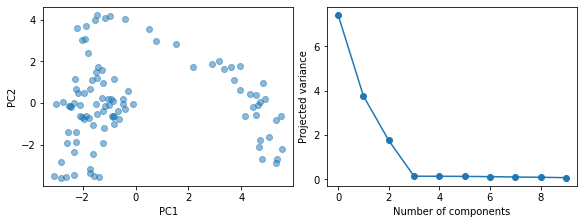

In [20]:
# Solution

# Generate the covariance matrix
Sigma = M_centered.T @ M_centered / M_centered.shape[0]

# Compute the eigenvalues using np.linalg.eig()
evals, evecs = np.linalg.eig(Sigma)

# Generate the projected data
projection = M_centered @ evecs

# Compute the variance using eigenvalues
projected_variance = np.var(projection,axis=0)


# Let's plot what we got
fig = plt.figure(figsize=(8,3), constrained_layout=True)
ax = fig.add_subplot(1,2,1)

ax.scatter(projection[:,0], projection[:,1], alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax = fig.add_subplot(1,2,2)
projected_variance = np.sort(projected_variance)[::-1]
ax.plot(projected_variance,'o-')
ax.set_xlabel('Number of components')
ax.set_ylabel('Projected variance')
plt.show()

**Step 5.** PCA is often used as a preprocessing step for other dimensionality reduction methods due to its denoising properties. Let's try to recompose the neural firing rates using the first two principal components. Does it look denoised to you? Try to change the number of components to see the difference.<br>


In [ ]:
n_components = 2

# Fill in your code below
##############################

# let's reconstruct the data by using only few components (always remember to put back the mean)
M_reconstructed = # your code here

##############################

fig = plt.figure(figsize=(10,3), constrained_layout=True)
ax = fig.add_subplot(1,2,1)

ax.set_title('Initial data')
ax.plot(ts, M)
ax.set_xlabel('Time')
ax.set_ylabel('Neural activity')

ax = fig.add_subplot(1,2,2)

ax.set_title('Reconstructed data')
ax.plot(ts, M_reconstructed)
ax.set_xlabel('Time')
ax.set_ylabel('Neural activity')
plt.show()

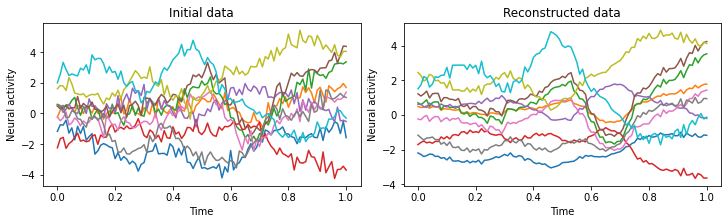

In [26]:
n_components = 2

# let's reconstruct the data by using only few components (always remember to put back the mean)
M_reconstructed = U[:,:n_components] @ np.diag(S[:n_components]) @ V[:n_components,:] + M.mean(axis=0)

fig = plt.figure(figsize=(10,3), constrained_layout=True)
ax = fig.add_subplot(1,2,1)

ax.set_title('Initial data')
ax.plot(ts, M)
ax.set_xlabel('Time')
ax.set_ylabel('Neural activity')

ax = fig.add_subplot(1,2,2)

ax.set_title('Reconstructed data')
ax.plot(ts, M_reconstructed)
ax.set_xlabel('Time')
ax.set_ylabel('Neural activity')
plt.show()

**Step 6.** A frequently used method to calculate the dimensionality is to plot the cumulative fraction of variance explained in the data and see when the curve levels off. Since the projected variance is given by the eigenvalues, this can be evaluated by a cumulative sum of eigenvalues normalized by the sum of all eigenvalues. Plot this as a function of the number of components. What do you think the dimensionality is?

In [ ]:
# Fill in your code below
##############################

# Compute the comulative (remember to normalize)
cumulative = # your code here

##############################

fig = plt.figure(figsize=(4,3), constrained_layout=True)
ax = fig.add_subplot()
ax.plot(cumulative, 'o-')
ax.set_xlabel('Number of components')
ax.set_ylabel('Variance explained')
plt.show()

(Text(0.5, 0, 'Number of components'), Text(0, 0.5, 'Variance explained'))

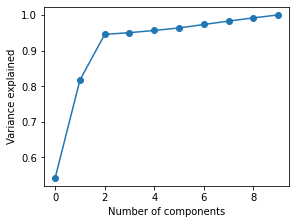

In [16]:
# Solution

# Compute the comulative (remember to normalize)
cumulative = np.cumsum(evals)/np.sum(evals)


fig = plt.figure(figsize=(4,3), constrained_layout=True)
ax = fig.add_subplot()
ax.plot(cumulative, 'o-')
ax.set_xlabel('Number of components')
ax.set_ylabel('Variance explained')
plt.show()

# **Part III.**  Cross-validating dataset dimensionality

A key step in dimensionality reduction methods is to determine the dimensionality of the data, that is to decide on the number of components to use. There exist two methods for doing it: (1) bi-cross-validation [6], which can be used for PCA, NMF, and similar matrix factorizations, and (2) masking entries of the data matrix or tensor during optimization, which is more general. Here, we will focus on ___bi-cross-validation___.

You can read more about cross-validation methods for PCA on this nice [blog post](https://alexhwilliams.info/itsneuronalblog/2018/02/26/crossval/).

## The method

### Bi-cross-validation for PCA

The SVD formulation of PCA allows for a very nice way to cross-validate the number of components [6]. The basic idea is that we will split the data into *two* test/training sets: one in neurons, and one in time. That is, we split the data matrix into block structure:
$\mathbf{X} = \begin{bmatrix} \mathbf{X}^{tr}_{tr} & \mathbf{X}_{tr}^{te}\\ \mathbf{X}_{te}^{tr} & \mathbf{X}^{te}_{te} \end{bmatrix}$.
The subscripts corresponds to neuron indices, and the superscripts to sample indices.

For each $R$, we use the truncated SVD on the data from *all* neurons during the *training* samples to identify the $R$ basis vectors:
$$\mathbf{X}^{tr} = \mathbf{U}_R\mathbf{Z}_{R}^{tr}$$
or, in block form:
$$\begin{bmatrix} \mathbf{X}^{tr}_{tr} \\ \mathbf{X}_{te}^{tr} \end{bmatrix} = \begin{bmatrix} \mathbf{U}_{R,tr} \\ \mathbf{U}_{R,te} \end{bmatrix} \mathbf{Z}_{R}^{tr}$$

We now want to cross-validate how well $\mathbf{U}_R$ describes the data in the test samples. This is in general ill-defined since we are moving from a low-dimensional subspace to a high-dimensional space, but the key idea is to use the *training* neurons in the *test* samples, in addition to the low-dimensional basis we just identified from the *training* samples, to predict the *test* neuron's activity in the *test* samples. Starting from the equivalent block formula for the test samples, we have:
$$\begin{bmatrix} \mathbf{X}^{te}_{tr} \\ \mathbf{X}_{te}^{te} \end{bmatrix} = \begin{bmatrix} \mathbf{U}_{R,tr} \\ \mathbf{U}_{R,te} \end{bmatrix} \mathbf{Z}_{R}^{te}$$

We first take advantage of the top block of the equation, using the basis we just identified, to obtain an estimate for the scores during the test samples $\mathbf{\hat Z}_{R}^{te}$, i.e. we solve the following linear regression problem:

$$\mathbf{X}^{te}_{tr} = \mathbf{U}_{R,tr}\mathbf{Z}_{R}^{te}$$
Now we plus this into the bottom block of the equation to obtain our estimate for the test neurons during test samples:
$$\mathbf{\hat X}^{te}_{te} = \mathbf{U}_{R,te}\mathbf{\hat Z}_{R}^{te}$$
We can now calculate the fraction of explained variance in the estimate as we [normally would](https://en.wikipedia.org/wiki/Fraction_of_variance_unexplained#:~:text=In%20statistics%2C%20the%20fraction%20of,by%20the%20explanatory%20variables%20X.):
$$ \text{frac var exp} = 1 - \frac{\text{MSE}}{\text{var}}$$
We repeat for different $R$ and as usual look for the value that maximizes the cross-validated explained variance.

There are a couple practicalities to note from this method that stem from the linear regression problem. First, note that the number of neurons in the training set has to be greater than $R$, or else the linear regression problem is underdetermined. This puts a limit to what dimensionalities we can test depending on how many neurons we can afford to use for training. Second, since we are using a subset of neurons to predict activity in other neurons, this method does not work well if the test neurons are independent of the training neurons. In other words it assumes some amount of shared variability between the neurons.

However, this formulation of bi-cross-validation is very particular to matrix decompositions and does not extend easily to tensors or to nonlinear methods.

### Cross-validation for tensors

To cross-validate other methods, we can simply hold out or mask entries of the data matrix/tensor while fitting the parameters of the model (e.g. the $\mathbf{u}$'s) on the remaining entries [4]. However, we must be careful to take into account temporal correlations since the tensor entries are not independently generated. That is, if we hold out single entries randomly throughout the matrix, the training and testing dataset will be strongly correlated. In fact, assuming the data is continuous in time (as would be the case for imaging data, or with firing rate estimates), with a sufficiently high sampling rate (i.e. sufficiently small time bins), the entry $\mathcal{X}_{i,j,k}$ of the data tensor (supposed to be in the test set) can be arbitrarily well approximated by averaging the $\mathcal{X}_{i,j-1,k}$ and $\mathcal{X}_{i,j+1,k}$ (which may both be in the train set). Instead, we advocate for holding out blocks and trimming the ends for the most fair separation between test and training data [5]. What timescale should we use? Some good bets are the timescale of the calcium indicator (imaging data) the smoothing kernel (for ephys). Or we can simply use the autocorrelation timescale for any arbitrary time series.

<p align="center" width="100%">
<img src="https://drive.google.com/uc?id=13dBa2-ccAWAeXf9oasoNJTO3bNvfPJOW" width="300px;">
</p>

## Application of PCA bi-cross validation on a toy dataset

Now we will move on to a more realistic  model, where the true rank of the data is unclear due to noise. We will use ___PCA bi-cross-validation___ to try to guess the cross-validated dimensionality. For this we will generate higher-dimensional data. Execute the following code to generate your new data matrix $M$ of 100 neurons and 500 time points to get started.

*(Note that for time series data we would need to be careful about temporal correlations between adjacent entries. In this particular tutorial we draw the samples from a multivariate Gaussian with no notion of time so we don't have to worry about it!)*

In [27]:
np.random.seed(1)

n = 100
k = np.random.randint(1, n//3+1) # Mystery rank
sample_size = 500
alpha = 0.0 # Noise term

u = np.random.randn(n, k)/np.sqrt(n*k)
v = np.random.randn(n, n)/np.sqrt(n*k)
C = u @ u.T + alpha*(v @ v.T) # Positive semi-definite symmetric matrix <= covariance matrix

M = np.random.multivariate_normal(np.random.randn(n)/np.sqrt(n), C, sample_size) + np.random.randn(sample_size, n)/10

print('Shapes:')
print('  Data matrix (sample_size, neuron):', M.shape)
print('  Covariance matrix (neuron, neuron):', C.shape)

Shapes:
  Data matrix (sample_size, neuron): (500, 100)
  Covariance matrix (neuron, neuron): (100, 100)


**Step 0.** Before starting, it is useful to define some helper functions, computing the mean squared error (MSE) and the explained variance, since we will use them a lot.

In [63]:
def compute_mse(prediction, target):
    """
    Function computing the mean squared error between predicted and target data
    Inputs: 
        prediction (numpy array): predicted values
        target (numpy array): target values
    returns:
        mse (float): mean squared error
    """
    # Fill in your code below
    ##############################
    return # your code
    ##############################
 
def compute_var_exp(prediction, target):
    """
    Function computing the variance explained between predicted and target data.
    It is usually defined as 1 - MSE/mean(target^2)
    Inputs: 
        prediction (numpy array): predicted values
        target (numpy array): target values
    returns:
        var_exp (float): variance explained
    """
    # Fill in your code below
    ##############################
    return # your code
    ##############################

In [28]:
# Solution

def compute_mse(prediction, target):
    """
    Function computing the mean squared error between predicted and target data
    Inputs: 
        prediction (numpy array): predicted values
        target (numpy array): target values
    returns:
        mse (float): mean squared error
    """
    return np.mean(((prediction-target)**2).flatten())
 
def compute_var_exp(prediction, target):
    """
    Function computing the variance explained between predicted and target data.
    It is usually defined as 1 - MSE/mean(target^2)
    Inputs: 
        prediction (numpy array): predicted values
        target (numpy array): target values
    returns:
        var_exp (float): variance explained
    """
    return 1 - compute_mse(prediction, target)/np.mean(((target)**2).flatten())

**Step 1.** Plot the cumulative fraction of variance explained in $M$ as a function of the number of principal components. You can use either the eigendecomposition or the SVD, as you prefer. Can you guess what the dimensionality is?

In [36]:
# Fill in your code below
##############################

# Center the data
M_centered = # your code

# Compute the explained variance
# your code here
#

# (if you use eigendecomposition, don't forget to sort the eigenvalues)
# your code here

# compute the cumulative fraction of variance explained (normalized)
cumulative = # your code here

##############################

fig = plt.figure(figsize=(6,3), constrained_layout=True)
ax = fig.add_subplot()
ax.plot(cumulative,'o-')
plt.show()


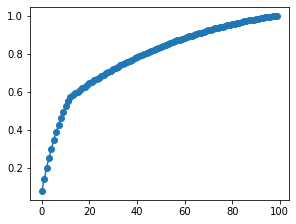

In [32]:
# Solution 1 (using eigen-decomposition)

# Center the data
M_centered = M - M.mean(axis=0)

# Compute the explained variance
Sigma = M_centered.T @ M_centered / M_centered.shape[0]
e_vals, e_vecs = np.linalg.eig(Sigma)

# (if you use eigendecomposition, don't forget to sort the eigenvalues)
e_vals = np.sort(e_vals)[::-1]

# compute the cumulative fraction of variance explained (normalized)
cumulative = np.cumsum(e_vals)/np.sum(e_vals)

fig = plt.figure(figsize=(4,3), constrained_layout=True)
ax = fig.add_subplot()
ax.plot(cumulative,'o-')
plt.show()

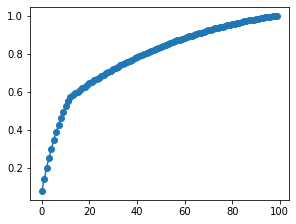

In [34]:
# Solution 2 (using SVD)

# Center the data
M_centered = M-M.mean(axis=0)

# Compute the explained variance
U, S, V = np.linalg.svd(M_centered, full_matrices=False)
e_vals = S**2/M_centered.shape[0]

# compute the cumulative fraction of variance explained (normalized)
cumulative = np.cumsum(e_vals)/np.sum(e_vals)
fig = plt.figure(figsize=(4,3), constrained_layout=True)
ax = fig.add_subplot()
ax.plot(cumulative,'o-')
plt.show()

**Step 2.** Now let's start the bi-cross-validation. Do the following steps.
* First (we already did it for you), split the data into training and test sets in both time and trials. We have written an example code using ```train_test_split``` from ```sklearn``` but feel free to modify / implement it your own way. Use 80% for training both in neurons and in time. Make sure it's clear to keep track of which indices are neurons and which are time.
* Second, choose a specific rank $r$ to first test your code. (But remember that it can't be larger than the number of neurons used for training)
* Third, apply PCA on the data for training samples (all neurons) using SVD.
* Next, use linear regression to solve for the scores in the test samples. You might want to use ```np.linalg.lstsq```.
* Finally, make a scatter plot of the actual data for the training neurons, test samples against the values you predicted from PCA and linear regression (also for training neurons, test samples - so it's not yet cross validated). Calculate and print the fraction of variance explained. How accurate is it?

In [ ]:
# Code for splitting the matrix into test/train neurons/samples
from sklearn.model_selection import train_test_split

# Creating the indeces for selecting train/test sets over samples/neurons
neur_indices_tr,neur_indices_te = train_test_split(np.arange(M.shape[1]), train_size = .8, shuffle=True)
time_indices_tr,time_indices_te = train_test_split(np.arange(M.shape[0]), train_size = .8, shuffle=True)

# Selecting the training and test data
M_tr_all = M_centered[time_indices_tr,:] # Note that data must be centered before!
M_te_all = M_centered[time_indices_te,:]
M_te_tr = M_te_all[:,neur_indices_tr]
M_te_te = M_te_all[:,neur_indices_te]


# Fill in your code below
############################

# Choose the rank r
# your code here

# Apply SVD on the training data
# your code here

# Now, we solve the scores with linear regression. Let's use 'u' for the train basis, 
# 'z' for the scores and 'x' forthe data
u = # your code here
x = # your code here

# Use linear regression ( a x = b) to solve the scores on test data
z = np.linalg.lstsq(u,x,rcond=None)[0]

# Compute the prediction
M_te_tr_predict = # your code here

############################

# Compute variance explained
var_exp_tr = compute_var_exp(M_te_tr_predict,M_te_tr)

fig = plt.figure(figsize=(4,3), constrained_layout=True)
ax = fig.add_subplot()
ax.scatter(M_te_tr_predict.flatten(), M_te_tr.flatten(),alpha=0.5)
ax.axline((0,0), (0.7,0.7), color='black', linestyle='--')
print(var_exp_tr)

Variance explained (train):  0.7371495246086921


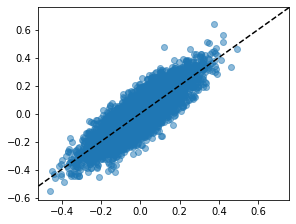

In [36]:
# Solution
from sklearn.model_selection import train_test_split

# Creating the indeces for selecting train/test sets over samples/neurons
neur_indices_tr,neur_indices_te = train_test_split(np.arange(M.shape[1]), train_size = .8, shuffle=True)
time_indices_tr,time_indices_te = train_test_split(np.arange(M.shape[0]), train_size = .8, shuffle=True)

# Selecting the training and test data
M_tr_all = M_centered[time_indices_tr,:]
M_te_all = M_centered[time_indices_te,:]
M_te_tr = M_te_all[:,neur_indices_tr]
M_te_te = M_te_all[:,neur_indices_te]

# Choose the rank r
r = 40

# Apply SVD on the training data
U, S, V = np.linalg.svd(M_tr_all, full_matrices=False)

# Now, we solve the scores with linear regression. Let's use 'u' for the train basis, 
# 'z' for the scores and 'x' forthe data
u = V[:r,neur_indices_tr].T
x = M_te_tr.T
# Use linear regression ( a x = b) to solve the scores on test data
z = np.linalg.lstsq(u,x,rcond=None)[0]

# Compute the prediction
M_te_tr_predict = (u @ z).T

# Compute variance explained
var_exp_tr = compute_var_exp(M_te_tr_predict,M_te_tr)

fig = plt.figure(figsize=(4,3), constrained_layout=True)
ax = fig.add_subplot()
ax.scatter(M_te_tr_predict.flatten(), M_te_tr.flatten(),alpha=0.5)
ax.axline((0,0), (0.7,0.7), color='black', linestyle='--')
print("Variance explained (train): ", var_exp_tr)

**Step 3.** Now we will try to do the cross validation to the test neurons, test samples data.
* Predict the activity of the test neurons in the test dataset. Make the same plot as in the last cell, and calculate the cross-validated fraction of variance explained. How does it compare to the previous step?
* Repeat this and the last cell for a few different choices of rank. What happens when the rank is very small ? Very large ?

In [ ]:
# Fill in your code below
##########################

# Compute the prediction on test neurons 
M_te_te_predict = # your code here

# Compute variance explained
var_exp_te = # your code here

##########################

fig = plt.figure(figsize=(4,4), constrained_layout=True)
ax = fig.add_subplot()
ax.scatter(M_te_te_predict.flatten(), M_te_te.flatten(),alpha=0.5)
ax.axline((-0.5,-0.5), (0.5,0.5), color='black', linestyle='--')
plt.show()

print("Variance explained (test): ",var_exp_te)

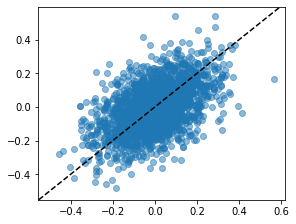

Variance explained (test):  0.027666380861396833


In [37]:
# Solution

# Compute the prediction on test neurons 
M_te_te_predict = (V[:r,neur_indices_te].T @ z).T

# Compute variance explained
var_exp_te = compute_var_exp(M_te_te_predict,M_te_te)

fig = plt.figure(figsize=(4,3), constrained_layout=True)
ax = fig.add_subplot()
ax.scatter(M_te_te_predict.flatten(), M_te_te.flatten(),alpha=0.5)
ax.axline((-0.5,-0.5), (0.5,0.5), color='black', linestyle='--')
plt.show()

print("Variance explained (test): ",var_exp_te)

**Step 4.** Here we will do the bi-cross-validation systematically to try to guess the rank.
* Copy/paste the code above into a loop to calculate the fraction of variance explained (both in training and test neurons) for different numbers of components. Test all possible dimensionalities.
* Plot the variance explained in both the training and test neurons over the number of components. What's the dimensionality?

In [ ]:

# enter here your guess for the rank
k_guess = 3


r_max = M_te_tr.shape[1]
dims = np.arange(1,r_max+1)
var_exp_tr = np.empty(dims.shape)
var_exp_te = np.empty(dims.shape)

for r in dims:
    # Reuse the last two cells of code for computing train/test explained variance
    # Fill in your code below
    ###########################

    



    ###########################

fig = plt.figure(figsize=(4,3), constrained_layout=True)
ax = fig.add_subplot()
ax.plot(dims,var_exp_tr,'-o', label = "train data")
ax.plot(dims,var_exp_te,'-o', label = "test data")
ax.legend()
ax.set_xlabel("Rank")
ax.set_ylabel("Variance explained")
ax.set_ylim([0,1.05])
plt.show()

k_guess = dims[np.argmax(var_exp_te)]

print("Computed rank: ", k_guess)
print("Real rank (the mistery rank k):", k)
print('Your guess was '+('Correct !' if your_guess == k_guess else 'Incorrect !'))

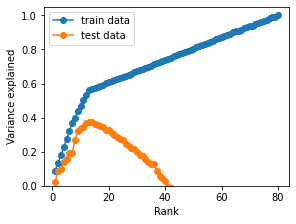

Computed rank:  13
Real rank (the mistery rank k): 13
Your guess was Incorrect !


In [40]:
# Solution

# enter here your guess for the rank
your_guess = 8

r_max = M_te_tr.shape[1]
dims = np.arange(1,r_max+1)
var_exp_tr = np.empty(dims.shape)
var_exp_te = np.empty(dims.shape)

# looping over all different ranks
for r in dims:
    # Reuse the last two cells of code for computing train/test explained variance

    # Apply SVD on the training data
    U, S, V = np.linalg.svd(M_tr_all, full_matrices=False)

    # Now, we solve the scores with linear regression. Let's use 'u' for the train basis, 
    # 'z' for the scores and 'x' forthe data
    u = V[:r,neur_indices_tr].T
    x = M_te_tr.T
    # Use linear regression ( a x = b) to solve the scores on test data
    z = np.linalg.lstsq(u,x,rcond=None)[0] # scores

    # Compute the prediction for training neurons
    M_te_tr_predict = (u @ z).T

    # Compute explained variance
    var_exp_tr[r-1] = compute_var_exp(M_te_tr_predict,M_te_tr)

    # Compute the prediction on test neurons
    M_te_te_predict = (V[:r,neur_indices_te].T @ z).T

    # Compute variance explained
    var_exp_te[r-1] = compute_var_exp(M_te_te_predict,M_te_te)

fig = plt.figure(figsize=(4,3), constrained_layout=True)
ax = fig.add_subplot()
ax.plot(dims,var_exp_tr,'-o', label = "train data")
ax.plot(dims,var_exp_te,'-o', label = "test data")
ax.legend()
ax.set_xlabel("Rank")
ax.set_ylabel("Variance explained")
ax.set_ylim([0,1.05])
plt.show()

k_guess = dims[np.argmax(var_exp_te)]

print("Computed rank: ", k_guess)
print("Real rank (the mistery rank k):", k)
print('Your guess was '+('Correct !' if your_guess == k_guess else 'not correct !'))

# **Part IV.** Application to neural data analysis

The data consists of microelectrode array recordings from M1 and PMd during a delayed center-out reach task. It is one of the datasets from the [Neural Latent Benchmark](https://neurallatents.github.io/) project, whose aim is to provide standardized freely accessible neural datasets for the sake of developing data analysis and modeling methods.



---



The task is a delayed center-out reach task with barriers, resulting in a variety of straight and curved trajectories. Neural activity was recorded from the dorsal premotor and primary motor cortices, and cursor, monkey gaze position, and monkey hand position and velocity are also provided. You can find more information on the dataset in the articles [7-8].

![](https://neurallatents.github.io/assets/maze_fig1.png)


---
It has been found that M1/PMd activity play a key role in motor control during this type of tasks.
___Today, we will explore this hypothesis by analyzing how the activity of the population of neurons is able to decode behavioral information.___

## Data imports

The neural data is presented in the Neurodata Without Border (NWB) format, which is a commonly used format for storing and sharing neural data. Here, all the code was written for you, you may just run the following cells, they will download the part of the dataset from this experiment which is relevant to this tutorial: one recording session. <br>
___Note that this can take a while (<5min) to run. So you should avoid restarting your runtime environment or rerunning those cells.___

### Run this:

No need to expand if you don't want to clutter your ipynb.

#### Import/install necessary libraries

In [3]:
# You should not evaluate this cell multiple times

from IPython.display import clear_output
from IPython.core.interactiveshell import InteractiveShell

# Download the data
!pip install git+https://github.com/neurallatents/nlb_tools.git
!pip install dandi
!pip install pydantic[email]

clear_output() #clear cell output

In [2]:
from nlb_tools.nwb_interface import NWBDataset
from IPython.display import clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
import pickle
from tqdm import tqdm

import scipy.ndimage as spnd
import scipy.stats as sps

np.random.seed(10)

/home/leo/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Download/load the raw dataset

The continuous data provided with the MC_Maze datasets includes:
* `cursor_pos` - x and y position of the cursor controlled by the monkey
* `eye_pos` - x and y position of the monkey's point of gaze on the screen, in mm
* `hand_pos` - x and y position of the monkey's hand, in mm
* `hand_vel` - x and y velocities of the monkey's hand, in mm/s, computed offline using `np.gradient`
* `spikes` - spike times binned at 1 ms

In [5]:
#The part of the dataset of interest

!dandi download https://gui.dandiarchive.org/#/dandiset/000128
dataset = NWBDataset("000128/sub-Jenkins/", "*train", split_heldout=False)
clear_output()

/usr/local/lib/python3.10/dist-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/usr/local/lib/python3.10/dist-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)
/usr/local/lib/python3.10/dist-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  if isna(x):
/usr/local/lib/python3.10/dist-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  else:


#### Dataset visualization (table)

In [6]:
dataset.data

In [7]:
dataset.trial_info

#### Dataset preparation

In [8]:
#The part of the dataset of interest
bin_size = 5 # ms
time_window = (-1000, 800)
timesteps = int((time_window[1]-time_window[0])//bin_size)
n_neurons = len(dataset.data.spikes.columns)

# resample the dataset
dataset.resample(bin_size)
# align trials to movement onset
alldata = dataset.make_trial_data(align_field='move_onset_time', align_range=time_window)

trials = alldata.trial_id.unique()
clear_output()

In [ ]:
trials = alldata.trial_id.unique()

nns = np.zeros([len(trials),n_neurons, timesteps]) # here we will save the neural activity
hhs = np.zeros([len(trials), 4, timesteps]) # here we will save the hand position
info_df = [] # this will contain the trial info

names = ['trial', 'ttype', 'tversion', 'target_x', 'target_y', 'success', 'num_targets', 'active']

for t, df in alldata.groupby('trial_id'):
    nns[t] = df.spikes.values.T
    hhs[t] = np.concatenate([df.hand_pos.values.T, df.hand_vel.values.T],axis=0)

    info_df.append([
        dataset.trial_info.trial_id[t],
        dataset.trial_info.trial_type[t],
        dataset.trial_info.trial_version[t],
        dataset.trial_info.target_pos[t][0][0], 
        dataset.trial_info.target_pos[t][0][1],
        dataset.trial_info.success[t],
        dataset.trial_info.num_targets[t],
        dataset.trial_info.active_target[t]
	])

info_df = pd.DataFrame(info_df, columns=names)

# here we extract a part of the dataset for faster computations
## Note that we selected sparser targets, for visualization purposes
cond = [26, 29, 1, 13, 32, 28, 33, 23, 10, 6 ,20, 38]

info_df = info_df.loc[info_df.num_targets==1]
info_df = info_df.loc[np.isin(info_df.ttype, cond)]

info_straight = info_df.loc[info_df.tversion==0].reset_index(drop=True)
info_curved = info_df.loc[info_df.tversion==1].reset_index(drop=True)

hand_straight = hhs[info_straight.trial.values]
hand_curved = hhs[info_curved.trial.values]

neurons_straight = nns[info_straight.trial.values]
neurons_curved = nns[info_curved.trial.values]

info_straight.to_pickle('info_straight.p')
info_curved.to_pickle('info_curved.p')

np.save('hand_straight.npy', hand_straight)
np.save('hand_curved.npy', hand_curved)

np.save('neurons_straight.npy', neurons_straight)
np.save('neurons_curved.npy', neurons_curved)

del alldata, dataset, nns, hhs, info_df, info_straight, info_curved, hand_straight, hand_curved, neurons_straight, neurons_curved

### Loading the dataset

Here, we load the neural data, behavioral data and extra trial data information. <br><br>
__We will mainly focus our analysis on the straight part of the dataset.__ <br><br>
You will also find a second part of the dataset relative to the curved trajectories (where the reaching is performed in the case of obstacles), that we will use only for comparison in few cases. Variables related to this second one will be generally named with a '_curved' at the end.

# Data format

Time window: (-1000, 800) ms

Bin size: 5 ms

Movement onset: 0 ms

Neural data shape (trials, neurons, time bins):
 (267, 182, 360)

Behavioral data shape (trials, x/y position + x/y velocity, time bins):
 (267, 4, 360)

trial_data (Dataframe) columns
 ['index', 'trial', 'ttype', 'tversion', 'target_x', 'target_y', 'success', 'num_targets', 'active', 'angle']
Target angles: [-0.7409829   0.40122882  2.4980917  -2.1672974  -0.57556987  1.5464109
  2.9410722  -0.14932266 -0.45756868  0.65351516 -2.5555823  -3.041924  ]


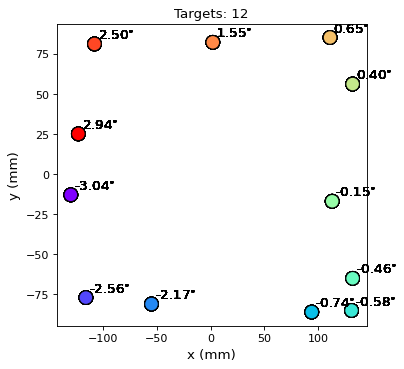

In [5]:
# loading neural and behavioral datasets
neural_data = np.load('neurons_straight.npy')
behavioral_data = np.load('hand_straight.npy')

# task variables
with open('info_straight.p', 'rb') as f:
    trial_data = pickle.load(f).reset_index()

# calculate target vangle and get index for sorting trials by target angle
trial_data['angle'] = np.arctan2(trial_data.target_y.values, trial_data.target_x.values)

# defining some useful constants
time_window = (-1000, 800) # ms
bin_size = 5 # ms
onset_time = -time_window[0]//bin_size
n_trials, n_neurons, timesteps = neural_data.shape
time_axis = np.arange(time_window[0], time_window[1], bin_size)

# Here, we define a color map for the different targets. You can use 't_map[angle]' for getting the color
targets = np.sort(trial_data['angle'].unique())
colors = matplotlib.cm.rainbow(np.linspace(0,1,len(targets)))
t_map = {angle: colors[i] for i, angle in enumerate(targets)}


print('\033[1;4m# Data format\033[0m\n')
print('Time window:', time_window, 'ms\n')
print('Bin size:', bin_size, 'ms\n')
print('Movement onset: 0 ms\n')
print('Neural data shape (trials, neurons, time bins):\n', neural_data.shape)
print('\nBehavioral data shape (trials, x/y position + x/y velocity, time bins):\n', behavioral_data.shape)
print('\ntrial_data (Dataframe) columns\n',list(trial_data.columns))
print('Target angles:', trial_data.angle.unique())

plt.figure(figsize=(5,5),dpi=80)
plt.title("Targets: %d" %len(trial_data['angle'].unique()),fontsize=12)
plt.scatter(trial_data.target_x,trial_data.target_y, s=150, color=[t_map[angle] for angle in trial_data['angle']], alpha=1, edgecolor='k')
for i in range(len(trial_data)):
    x,y,angle, ttype = trial_data.loc[i,['target_x','target_y','angle','ttype']]
    plt.text(x+3,y+3,f'${angle/np.pi*180:.2f}^\circ$',fontsize=12)
plt.ylabel('y (mm)',fontsize=12)
plt.xlabel('x (mm)',fontsize=12)
plt.show()


## Simple statistics

A common first step when analyzing a new piece of data is to do basic statistics and plotting to get a sense of the data: "are there near-silent neurons?", "is the behavior stereotypic?", "are trials of similar durations?" are typical questions which might be relevant to answer before starting applying complex models or data analysis methods to the data.

### Analysis of behavior

__Step 1 (Hand Trajectories).__ First, let's plot the hand trajectories. Try to make two subplots where trajectories are color coded by the target angle (present in the trail_data).
- In the first plot, plot all the color coded trajectories
- in the second plot, just plot the mean trajectory for each target angle

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6), dpi=60,constrained_layout=True)

# let's extract the angles from trial_data
angles = trial_data['angle'].values

# Here, we define a color map for the different targets. You can use 't_map[angle]' for getting the color
targets = np.sort(trial_data['angle'].unique())
colors = matplotlib.cm.rainbow(np.linspace(0,1,len(targets)))
t_map = {angle: colors[i] for i, angle in enumerate(targets)}

for trial_id,trial_traj in enumerate(behavioral_data):
    # Fill in your code below
    ###############################
    # remember that trials and angles are in the same order
    angle = # your code

    ax[0].plot() # your code here
    ###############################

ax[0].set_xlabel('x (mm)')
ax[0].set_ylabel('y (mm)')
ax[0].set_title('Hand movement, different trials')

for angle in targets:
    # Fill in your code below
    ###############################
    # create the index vector, for selecting the trajectories
    indeces = # your code here

    # extract the trajectories and compute the mean over trials
    mean_trajectory = # your code here

    ax[1].plot() #your code here
    ###############################

ax[1].set_xlabel('x (mm)')
ax[1].set_ylabel('y (mm)')
ax[1].set_title('Hand movement, average trajectory')


plt.show()

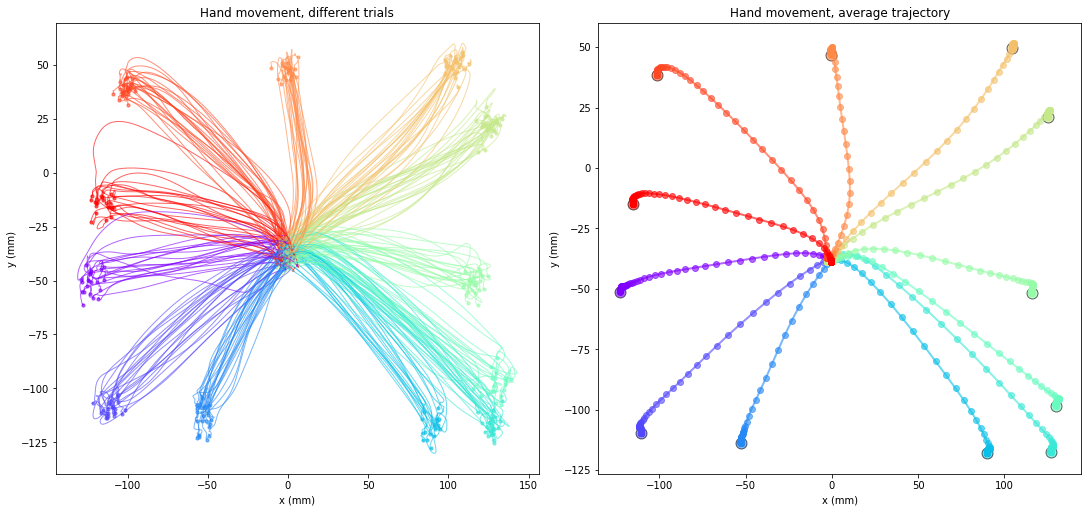

In [6]:
# Solution

fig, ax = plt.subplots(1,2,figsize=(15,7),constrained_layout=True)

# let's extract the angles from trial_data
angles = trial_data['angle'].values

# Here, we define a color map for the different targets. You can use 't_map[angle]' for getting the color
targets = np.sort(trial_data['angle'].unique())
colors = matplotlib.cm.rainbow(np.linspace(0,1,len(targets)))
t_map = {angle: colors[i] for i, angle in enumerate(targets)}

for trial_id,trial_traj in enumerate(behavioral_data):
    angle = angles[trial_id]
    ax[0].plot(trial_traj[0,:], trial_traj[1,:], c=t_map[angle], alpha=0.6, linewidth=1)
    ax[0].scatter(trial_traj[0,-1], trial_traj[1,-1], color=t_map[angle], alpha=0.6,s=10)

ax[0].set_xlabel('x (mm)')
ax[0].set_ylabel('y (mm)')
ax[0].set_title('Hand movement, different trials')

for angle in targets:
    # create the index vector, for selecting the trajectories
    indeces = (angles == angle)

    # extract the trajectories and compute the mean over trials
    mean_trajectory = behavioral_data[indeces].mean(axis = 0)

    ax[1].plot(mean_trajectory[0,::2], mean_trajectory[1,::2], 'o-',c=t_map[angle], alpha=0.6, linewidth=2,markersize=6)
    ax[1].scatter(mean_trajectory[0,-1], mean_trajectory[1,-1], color=t_map[angle], alpha=0.6,s=120,edgecolor='k')

ax[1].set_xlabel('x (mm)')
ax[1].set_ylabel('y (mm)')
ax[1].set_title('Hand movement, average trajectory')


plt.show()

As you can see, the animal perform stereotyped, slightly curved trajectories.

__Step 2 (Hand Velocity).__ Let's now plot the hand velocity. You can reuse the same code, just selecting the indeces in the behavioral_data matrix corresponding to velocity.

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6), dpi=60,constrained_layout=True)

# let's extract the angles from trial_data
angles = trial_data['angle'].values

# Here, we define a color map for the different targets.
# You can use 't_map[angle]' for getting the color
targets = np.sort(trial_data['angle'].unique())
colors = matplotlib.cm.rainbow(np.linspace(0,1,len(targets)))
t_map = {angle: colors[i] for i, angle in enumerate(targets)}

for trial_id,trial_traj in enumerate(behavioral_data):
    # Fill in your code below
    ###############################
    # remember that trials and angles are in the same order
    angle = # your code

    ax[0].plot() # your code here
    ###############################

ax[0].set_xlabel('x (mm/s)')
ax[0].set_ylabel('y (mm/s)')
ax[0].set_title('Hand velocity, different trials')

for angle in targets:
    # Fill in your code below
    ###############################
    # create the index vector, for selecting the trajectories
    indeces = # your code here

    # extract the trajectories and compute the mean over trials
    mean_trajectory = # your code here
    
    ax[1].plot()

ax[1].set_xlabel('x (mm/s)')
ax[1].set_ylabel('y (mm/s)')
ax[1].set_title('Hand velocity, average')


plt.show()

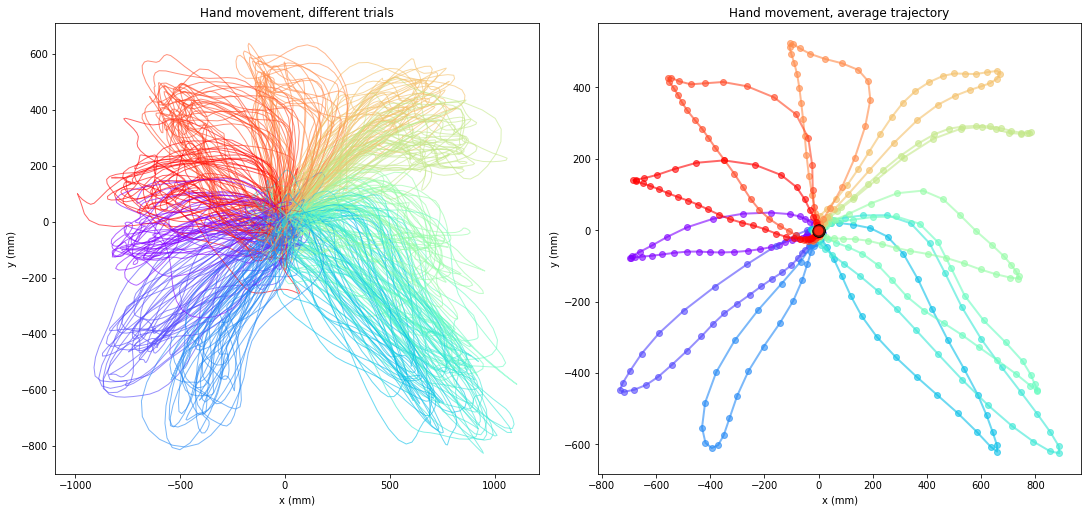

In [7]:
# Solution

fig, ax = plt.subplots(1,2,figsize=(15,7),constrained_layout=True)

# let's extract the angles from trial_data
angles = trial_data['angle'].values

# Here, we define a color map for the different targets. You can use 't_map[angle]' for getting the color
targets = np.sort(trial_data['angle'].unique())
colors = matplotlib.cm.rainbow(np.linspace(0,1,len(targets)))
t_map = {angle: colors[i] for i, angle in enumerate(targets)}

for trial_id,trial_traj in enumerate(behavioral_data):
    angle = angles[trial_id]
    ax[0].plot(trial_traj[2,:], trial_traj[3,:], c=t_map[angle], alpha=0.6, linewidth=1)
    ax[0].scatter(trial_traj[2,-1], trial_traj[3,-1], color=t_map[angle], alpha=0.6,s=10)

ax[0].set_xlabel('x (mm)')
ax[0].set_ylabel('y (mm)')
ax[0].set_title('Hand movement, different trials')

for angle in targets:
    # create the index vector, for selecting the trajectories
    indeces = (angles == angle)

    # extract the trajectories and compute the mean over trials
    mean_trajectory = behavioral_data[indeces].mean(axis = 0)

    ax[1].plot(mean_trajectory[2,::2], mean_trajectory[3,::2], 'o-',c=t_map[angle], alpha=0.6, linewidth=2,markersize=6,zorder=1)
    ax[1].scatter(mean_trajectory[2,-1], mean_trajectory[3,-1], color=t_map[angle], alpha=0.6,s=120,edgecolor='k', zorder=2)

ax[1].set_xlabel('x (mm)')
ax[1].set_ylabel('y (mm)')
ax[1].set_title('Hand movement, average trajectory')


plt.show()

Much more messy right? Before moving on, just try to spot the main differences between trajectories and velocities! What do you see?

__Step 3.__ Here, we plot the single x or y velocities, for gaining some information on movement timing.

In [ ]:
# Solution

fig, ax = plt.subplots(3,1,figsize=(5,7), dpi=100, constrained_layout=True)

chosen_angles = targets[[2,5,10]]

for a in chosen_angles:

    # Fill in your code below
    ############################

    # create the index vector for selected angle and extract the trajectories
    indeces = # your code here
    velocities = # your code here

    ### Plotting hand mean velocity

    # compute the velocity module, mean/std over trials
    velocity_module = # your code here
    mean_module = # your code here
    std_module = # your code here

    ############################

    # let's plot mean and std
    ax[0].plot(time_axis, mean_module, 
               c=t_map[a], linewidth=1, label=f'${a/np.pi*180:.2f}^\circ$')
    ax[0].fill_between(time_axis, 
                       mean_module-std_module, 
                       mean_module+std_module, 
                       color=t_map[a], alpha=0.2)

    ### Plotting hand x-velocity

    # Fill in your code below
    ############################

    # compute the x_velocity module, mean/std over trials
    x_velocity = # your code here
    x_velocity_mean = # your code here
    x_velocity_std = # your code here

    ############################

    # 
    ax[1].plot(time_axis, x_velocity_mean, 
               c=t_map[a], linewidth=1, label=f'${a/np.pi*180:.2f}^\circ$')
    ax[1].fill_between(time_axis, 
                       x_velocity_mean-x_velocity_std, 
                       x_velocity_mean+x_velocity_std, 
                       color=t_map[a], alpha=0.2)

    ### Plotting hand y-velocity

    # Fill in your code below
    ############################

    # compute the x_velocity module, mean/std over trials
    y_velocity = # your code here
    y_velocity_mean = # your code here
    y_velocity_std = # your code here

    ############################

    ax[2].plot(time_axis, y_velocity_mean, 
               c=t_map[a], linewidth=1, label=f'${a/np.pi*180:.2f}^\circ$')
    ax[2].fill_between(time_axis, 
                       y_velocity_mean-y_velocity_std, 
                       y_velocity_mean+y_velocity_std, 
                       color=t_map[a], alpha=0.2)

# Some settings
ax[0].set_title('Hand velocity module')
ax[0].set_ylabel('|Velocity| (mm/s)')
ax[1].set_title('Hand x-velocity')
ax[1].set_ylabel('Velocity (mm/s)')
ax[2].set_title('Hand y-velocity')
ax[2].set_ylabel('Velocity (mm/s)')
for i in range(3):
    ax[i].vlines(0, -700,1400, color='k', linestyle='--', linewidth=1, label = 'mov. onset',zorder=3)
    ax[i].set_ylim(-700,1400)
    ax[i].legend(loc='upper left')
    ax[i].set_xlabel('Time (ms)')
plt.show()

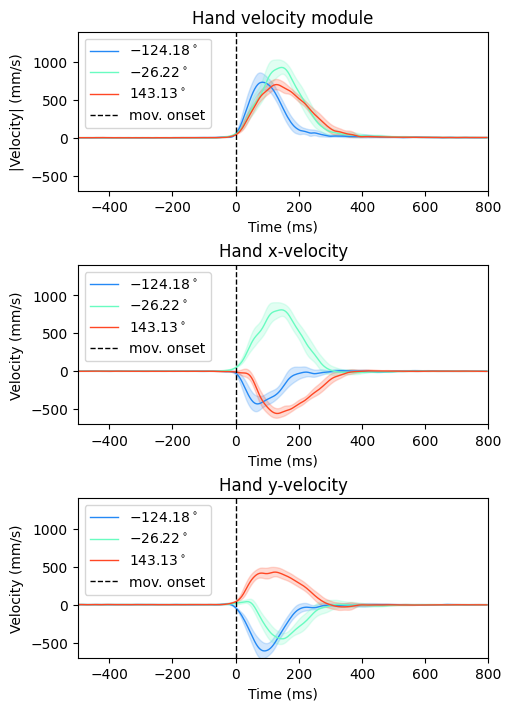

In [34]:
# Solution

fig, ax = plt.subplots(3,1,figsize=(5,7), dpi=100, constrained_layout=True)

chosen_angles = targets[[2,5,10]]

for a in chosen_angles:

    # create the index vector for selected angle and extract the trajectories
    indeces = (angles == a)
    velocities = behavioral_data[indeces, 2:]

    ### Plotting hand mean velocity
    # compute the velocity module, mean/std over trials
    velocity_module = np.linalg.norm(velocities, axis=1)
    mean_module = velocity_module.mean(axis=0)
    std_module = velocity_module.std(axis=0)
    
    # let's plot mean and std
    ax[0].plot(time_axis, mean_module, 
               c=t_map[a], linewidth=1, label=f'${a/np.pi*180:.2f}^\circ$')
    ax[0].fill_between(time_axis, 
                       mean_module-std_module, 
                       mean_module+std_module, 
                       color=t_map[a], alpha=0.2)


    ### Plotting hand x-velocity
    # compute the x_velocity module, mean/std over trials
    x_velocity = velocities[:,0]
    x_velocity_mean = x_velocity.mean(axis=0)
    x_velocity_std = x_velocity.std(axis=0)
    ax[1].plot(time_axis, x_velocity_mean, 
               c=t_map[a], linewidth=1, label=f'${a/np.pi*180:.2f}^\circ$')
    ax[1].fill_between(time_axis, 
                       x_velocity_mean-x_velocity_std, 
                       x_velocity_mean+x_velocity_std, 
                       color=t_map[a], alpha=0.2)

    ### Plotting hand y-velocity
    # compute the y_velocity module, mean/std over trials
    y_velocity = velocities[:,1]
    y_velocity_mean = y_velocity.mean(axis=0)
    y_velocity_std = y_velocity.std(axis=0)
    ax[2].plot(time_axis, y_velocity_mean, 
               c=t_map[a], linewidth=1, label=f'${a/np.pi*180:.2f}^\circ$')
    ax[2].fill_between(time_axis, 
                       y_velocity_mean-y_velocity_std, 
                       y_velocity_mean+y_velocity_std, 
                       color=t_map[a], alpha=0.2)

# Some other settings
ax[0].set_title('Hand velocity module')
ax[0].set_ylabel('|Velocity| (mm/s)')
ax[1].set_title('Hand x-velocity')
ax[1].set_ylabel('Velocity (mm/s)')
ax[2].set_title('Hand y-velocity')
ax[2].set_ylabel('Velocity (mm/s)')
for i in range(3):
    ax[i].vlines(0, -700,1400, color='k', linestyle='--', linewidth=1, label = 'mov. onset',zorder=3)
    ax[i].set_ylim(-700,1400)
    ax[i].set_xlim(-500,800)
    ax[i].legend(loc='upper left')
    ax[i].set_xlabel('Time (ms)')
plt.show()

What do you observe? Is there some parts of the data data might not be useful to include for our analysis?

### Analysis of the neural data

#### Neuron-wise average

Plot a histogram of the average number of spikes per trial for all neurons.

In [ ]:
# Fill in your code below

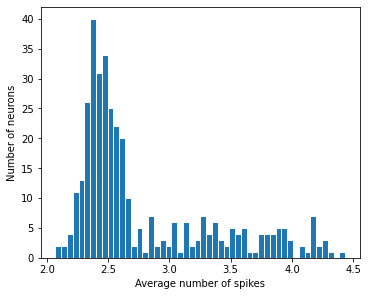

In [40]:
# Solution

fig = plt.figure(figsize=(5,4), constrained_layout=True)
ax = fig.add_subplot()

ax.hist(neural_data.sum(axis=1).mean(axis=0), bins=50, edgecolor='w')

ax.set_xlabel('Average number of spikes')
ax.set_ylabel('Number of neurons')
plt.show()

*  What do you observe? (You can use more (~50) bins for improving visualization)

The histogram seems to be composed by a pool of neurons spiking around 2.5 times per trial, normally distributed, plus a ~ uniform distribution of neurons spiking at any range from 2 to 4.5 times per trial (___on average___)

#### Time-wise average

We plot now the average (over neurons and trials) number of spikes as a function of time, and the same with its standard deviation to compare them.

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,4),constrained_layout=True)

# Fill in your code below
##############################

# Compute the mean and standard deviation of the activity
mean_activity = # your code here
std_activity = # your code here

ax[0].plot() # your code here

ax[1].plot() # your code here
ax[1].fill_between() # your code here

##############################


# other settings
ax[0].axvline(0, color='red', label='mov. onset', linestyle='--')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Average number of spikes')
ax[0].legend()
ax[1].axvline(0, color='red', label='mov. onset', linestyle='--')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Average number of spikes')
ax[1].legend()

plt.show()

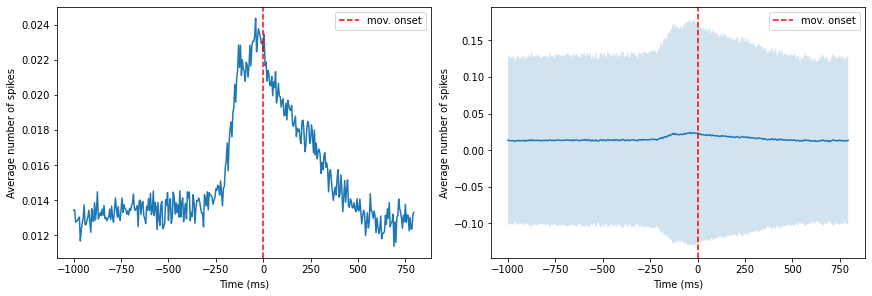

In [49]:
# Solution 

mean_activity = neural_data.mean(axis=(0,1))
std_activity = neural_data.std(axis=(0,1))

fig, ax = plt.subplots(1,2,figsize=(12,4),constrained_layout=True)

ax[0].plot(time_axis, mean_activity)
ax[0].axvline(0, color='red', label='mov. onset', linestyle='--')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Average number of spikes')
ax[0].legend()

ax[1].plot(time_axis, mean_activity)
ax[1].fill_between(time_axis, mean_activity-std_activity, mean_activity+std_activity, alpha=0.2)
ax[1].axvline(0, color='red', label='mov. onset', linestyle='--')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Average number of spikes')
ax[1].legend()

plt.show()

*  What do you observe? Could we guess something from this plot?

Answer: There are two peaks of activity, one around -130 ms and the other around -50 ms. After onset, the activity slowly goes to the initial level. There is a lot of variability from the data.

#### Tuning

Next we will explore whether neurons are tuned to bump directions. To this end, we will sort the the trials according to reach direction, and average over the time period from -50ms to 200ms the activity of three example neurons.

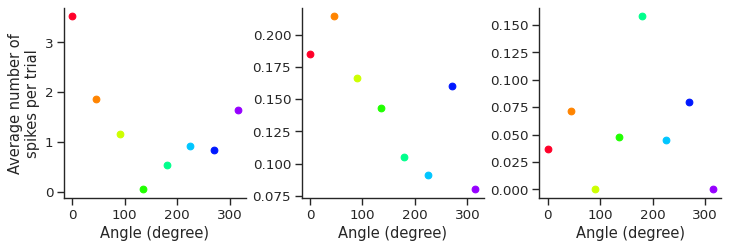

In [13]:
Index_of_neurons_plotted = [0, 1, 2]

fig, axes = plt.subplots(1, len(Index_of_neurons_plotted),
              figsize=(3*len(Index_of_neurons_plotted),3), constrained_layout=True)

cmap = matplotlib.colormaps['gist_rainbow']

unique_angle = np.unique(angle)

sorted_id = np.argsort(angle)
sorted_angle = angle[sorted_id]

for i in Index_of_neurons_plotted:
  for a in unique_angle:

    axes[i].scatter(a, neural_data[angle==a,5:30].sum(axis=1).mean(axis=0)[i], color=cmap(a/360))

  axes[i].set_xlabel('Angle (degree)')

axes[0].set_ylabel('Average number of\nspikes per trial')

*  Qualitatively comment on the tuning of these three neurons (you may want to look at other neurons).

Answer: little apparent tuning.

As it turns out, while the activity of single neurons is poorly tuned to bump direction, the activity of the population of neurons as a whole is highly stereotypical for a given bump direction. We will therefore build a model of the population rather than of single neurons. But before using this model we need to verify that it is a valid one based on simpler statistics.

## Dimensionality reduction

The above approaches have a key pitfall: information about the data is lost when averaging, and we fail to find properties of the whole neural population when looking at single neurons. We therefore turn to dimensionality reduction.

First, we will create firing rate estimates from the spiking data by applying a Gaussian filter. Additionally, we z-score the data.

NB:
```
neural_data (trial, time, neuron) : (17, 60, 65)
hand_movement (trial, time, position) : (171, 60, 2)
angle (trial) : (171)
```

In [ ]:
gaussian_filter_std = 4 # 40ms

# To Gaussian filter the data we use scipy's built-in function
# axis=1 specifies that we want to smooth the data over the time dimension
rate_neural_data = scipy.ndimage.gaussian_filter1d(neural_data.astype(np.float32),
                                                   sigma=gaussian_filter_std,
                                                   axis=1)

# Centering, axis=(0,1) specifies that we want to compute the mean per-neuron
rate_neural_data = rate_neural_data-rate_neural_data.mean(axis=(0,1))

# Normalizing
rate_neural_data = rate_neural_data/rate_neural_data.std(axis=(0,1))

### Neural covariability with PCA

**Step 1.** Apply PCA to the neuron-unfolded neural data. That is, infer the correct $\mathbf{U}$, $\mathbf{S}$ and $\mathbf{V}$

In [ ]:
# Fill in your code below

In [ ]:
# Solution

# Shape : -1 x neuron
neuron_unfolded_rate_neural_data = rate_neural_data.reshape(-1, rate_neural_data.shape[-1])

_, _, V_neuron = np.linalg.svd(neuron_unfolded_rate_neural_data,
                        full_matrices=False)

# We project the data. Shape: trial x time x principal_component
rate_neural_data_on_neural_pc = rate_neural_data @ V_neuron.T

**Step 2.** Plot cumulative variance explained as a function of the number of principal components.

In [ ]:
# Fill in your code below

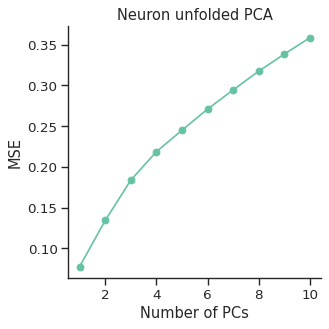

In [ ]:
# Solution

max_pc = 10

var_exp_neuron_unfolded = [1-((rate_neural_data - rate_neural_data_on_neural_pc[..., :number_of_pc] @ V_neuron[:number_of_pc])**2).mean()/rate_neural_data.var() for number_of_pc in range(1, max_pc+1)]

fig = plt.figure(figsize=(4,4), constrained_layout=True)
ax = fig.add_subplot()

ax.plot(np.arange(1, max_pc+1), var_exp_neuron_unfolded, '-o')
ax.set_xlabel('Number of PCs'), ax.set_ylabel('MSE')
ax.set_title('Neuron unfolded PCA')

**Step 3.**

* Plot the neural activity along the first three PCs in a 3D space.
* Color each trajectory by the bump angle.
* If you find it clearer, you may start by plotting trajectories of only two bump angles.

As a reminder, the variable `angle` is a ndarray of shape (trial) containing the angle in degree.

In [ ]:
# Fill in your code below

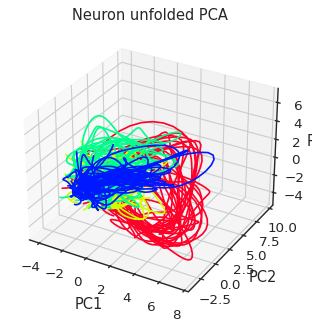

In [ ]:
# Solution

fig = plt.figure(figsize=(4,4), constrained_layout=True)
ax = fig.add_subplot(projection='3d')

cmap = matplotlib.colormaps['gist_rainbow']

unique_angles = np.sort(np.unique(angle))

for current_angle in unique_angles[::2]: #Only every other angle
  trajectories = rate_neural_data_on_neural_pc[angle==current_angle]
  for trajectory in trajectories:
    ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2],
          color = cmap(current_angle/360))

ax.set_xlabel('PC1'), ax.set_ylabel('PC2'), ax.set_zlabel('PC3')
ax.set_title('Neuron unfolded PCA')

* What do you observe?

Answer: Trajectories seem to be somewhat clustered by angle, but not much.

### Trial covariability with PCA

**Step 4.** As before:
* Apply PCA to the **trial**-unfolded neural data.
* Plot cumulative variance explained as a function of the number of principal components.

In [ ]:
# Fill in your code below

In [ ]:
# Solution

# Shape : -1 x trial
trial_unfolded_rate_neural_data = rate_neural_data.swapaxes(0,2).reshape(-1, rate_neural_data.shape[0])

_, _, V_trial = np.linalg.svd(trial_unfolded_rate_neural_data,
                        full_matrices=False)

# We project the data. Shape: neuron x time x principal_component
rate_neural_data_on_trial_pc = rate_neural_data.swapaxes(0,2) @ V_trial.T

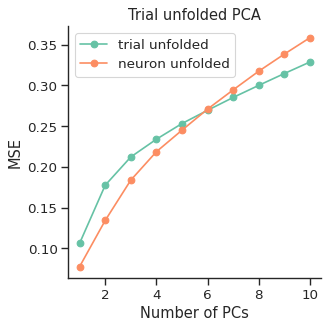

In [ ]:
# Solution

max_pc = 10

var_exp_trial_unfolded = [1-((rate_neural_data.swapaxes(0,2) - rate_neural_data_on_trial_pc[..., :number_of_pc] @ V_trial[:number_of_pc])**2).mean()/rate_neural_data.var() for number_of_pc in range(1, max_pc+1)]

fig = plt.figure(figsize=(4,4), constrained_layout=True)
ax = fig.add_subplot()

ax.plot(np.arange(1, max_pc+1), var_exp_trial_unfolded, '-o', label='trial unfolded')
ax.plot(np.arange(1, max_pc+1), var_exp_neuron_unfolded, '-o', label='neuron unfolded')

ax.set_xlabel('Number of PCs'), ax.set_ylabel('MSE')
ax.set_title('Trial unfolded PCA')
ax.legend()

* Compare this with the equivalent neuron-unfolded plot. What is missing to really assess how much of the data is captured by each unfolding?

Answer: For few PCs, more variance is explained by trial unfolding; vice versa for many PCs. What's missing is cross-validation.

**Step 5.** Plot the trial PCs, which, as a reminder are of shape #trials. Additionally sort and color code them by angle.

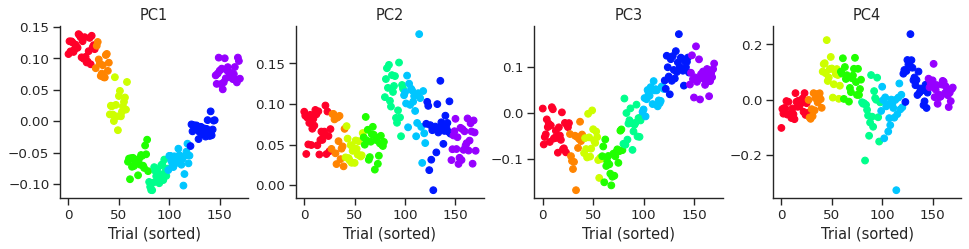

In [ ]:
pcs_to_plot = 4

fig, axes = plt.subplots(1, pcs_to_plot, figsize=(3*pcs_to_plot,3), constrained_layout=True)

cmap = matplotlib.colormaps['gist_rainbow']

unique_angles = np.sort(np.unique(angle))

for i in range(pcs_to_plot):
    axes[i].scatter(np.arange(len(V_trial)), V_trial[i], color = cmap(angle/360))

    axes[i].set_xlabel('Trial (sorted)')
    axes[i].set_title('PC'+str(i+1))

\* Compare this to the tuning observed at the level of single neurons.

Answer: Better.

### Mixed covariability with SliceTCA

We didn't get a very clear answer as to which of trial or neural unfolding was capturing more of the data. Which may mean both classes of variability are mixed within the data. To explore this, we use sliceTCA [4].

In the process, we will take a more systematic approach to uncover the right number of trial and neural slicing components: cross-validated grid-search. We have already ran such gridsearch for you, and found that trial=8, time=0, neuron=1 -slicing components best explain the data.

<div>
<img src="https://drive.google.com/uc?id=1rl3sDPOhGITyWo6663Q_O9ymbGAZL0MN" width="600px;">
</div>

The code for the next few steps has been written for you.

**Step 1.** Run the following cell to install the sliceTCA library.

In [ ]:
!pip install slicetca
import slicetca

**Step 2.** Run the following cell to fit a 8 trial slicing (a.k.a. unfolding) 0 time slicing and 1 neuron slicing components.

In [ ]:
components, model = slicetca.decompose(rate_neural_data, number_components=[8,0,1])

The model converged. MSE loss: 0.6790468692779541 :  45%|████▌     | 4514/10000 [00:27<00:33, 165.10it/s]


In case you want to further analyze them, the variables returned by the ``slicetca.decompose`` are as follows:

* ``components`` is a list[list[tensor]] of shape ``component type x [factor, slice] x rank x dimension``. The component types are ordered by the factors. That is, to access the neuron factor of the k th neuron-slicing component ``components[2][0][k]``.

* ``model`` is a ``SliceTCA`` object which contains various useful methods and attributes.

**Step 3.** We plot the loss.

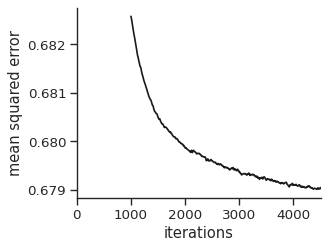

In [ ]:
fig = plt.figure(figsize=(4,3), constrained_layout=True)
ax = fig.add_subplot()

ax.plot(np.arange(1000,len(model.losses)), model.losses[1000:], 'k')
ax.set_xlabel('iterations')
ax.set_ylabel('mean squared error')
ax.set_xlim(0,len(model.losses))

**Step 4.**. Finally, we plot the components.

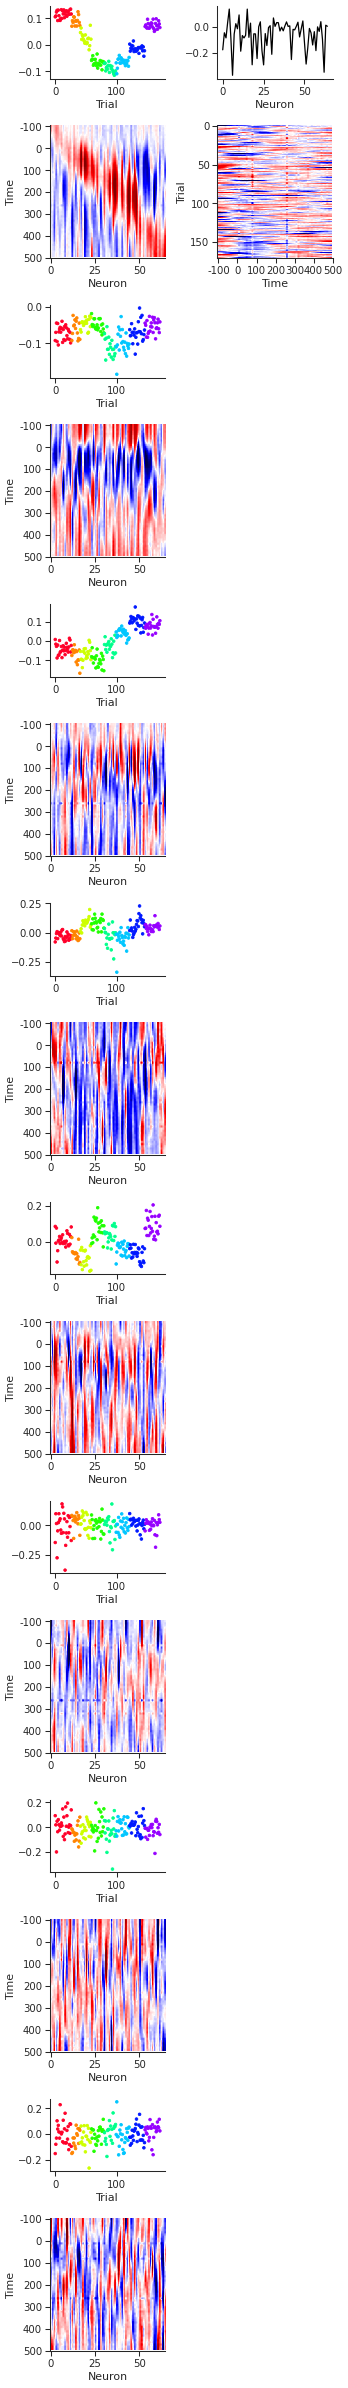

In [ ]:
cmap = matplotlib.colormaps['gist_rainbow']

# define colors for each trial based on target angle
trial_colors = np.array([cmap(i/360) for i in angle])

# we sort the neurons of the trial slices according to their peak activity in the first slice.
neuron_sorting_peak_time = np.argsort(np.argmax(components[0][1][0], axis=0))

# we sort the trial
trial_idx = np.argsort(angle)

# call plotting function, indicating index for sorting trials and colors for different angles as well as time
axes = slicetca.plot(model,
              variables=('Trial', 'Time', 'Neuron'),
              colors=(trial_colors[trial_idx], None, None), # we only want the trials to be colored
              ticks=(None, np.linspace(0, rate_neural_data.shape[1], 7), None), # we only want to modify the time ticks
              tick_labels=(None, np.linspace(-100,500,7).astype(int), None),
              sorting_indices=(trial_idx, None, neuron_sorting_peak_time),
              quantile=0.99)

Similarly to how for PCA we had to constrain the factors to be orthonormal, sliceTCA has different invariance classes.

**Step 5.**
* To select a unique model you may run the following cell.
* Rerun the previous plotting cell. How do the trial factors compare to those of trial-unfolding PCA?

In [ ]:
slicetca.invariance(model)
components = model.get_components(numpy=True)

The invariance converged. Invariance loss: 0.32182395458221436 :   5%|▍         | 479/10000 [00:03<01:08, 138.18it/s]


**Step 6.** (You'll have to implement this one yourself!)
* Project the following on the principal components computed on the neuron unfolding of the sliceTCA reconstruction.
 * The neural data
 * The sliceTCA reconstruction

In [ ]:
# The tensors you have to project. Shape : model x trial x time x neuron
full_tensors = np.stack([rate_neural_data,
                         model.construct().numpy(force=True)])
labels = ['Raw', 'SliceTCA']

tensor_to_compute_pcs = full_tensors[1]

In [ ]:
# Fill in your code below

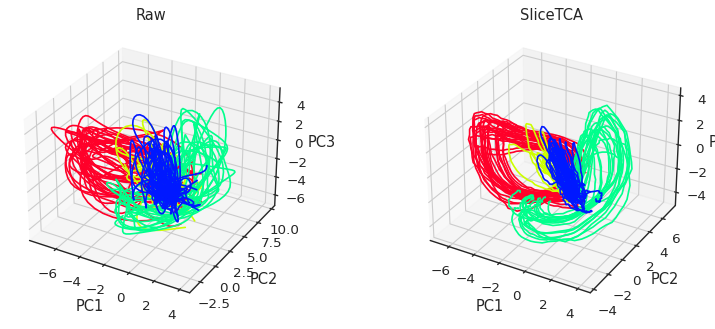

In [ ]:
# Solution

fig = plt.figure(figsize=(5*len(full_tensors),4), constrained_layout=True)
axs = [fig.add_subplot(1,len(full_tensors), 1+i, projection='3d') for i in range(len(full_tensors))]

cmap = matplotlib.colormaps['gist_rainbow']

unique_angles = np.sort(np.unique(angle))

neuron_unfolded_data = tensor_to_compute_pcs.reshape(-1, tensor_to_compute_pcs.shape[-1])

_, _, V_neuron = np.linalg.svd(neuron_unfolded_data, full_matrices=False)

# We project the data. Shape: model x trial x time x principal_component
projected_tensors = full_tensors @ V_neuron.T

for axi, ax in enumerate(axs):
  for current_angle in unique_angles[::2]: #Only every other angle
    trajectories = projected_tensors[axi,angle==current_angle]
    for trajectory in trajectories:
        ax.plot(trajectory[:, 0],
                trajectory[:, 1],
                trajectory[:, 2],
                color = cmap(current_angle/360))

  ax.set_xlabel('PC1'), ax.set_ylabel('PC2'), ax.set_zlabel('PC3')
  ax.set_title(labels[axi])


* Comment on the results.

Answer: SliceTCA seems to denoise the data.

# References

[1] Cunningham, J. P., & Yu, B. M. (2014). Dimensionality reduction for large-scale neural recordings. Nature neuroscience, 17(11), 1500-1509.

[2] Bishop, C. M. (2009). Pattern recognition and machine learning. Springer, New York.

[3] Seely, J. S., Kaufman, M. T., Ryu, S. I., Shenoy, K. V., Cunningham, J. P., & Churchland, M. M. (2016). Tensor analysis reveals distinct population structure that parallels the different computational roles of areas M1 and V1. PLoS computational biology, 12(11), e1005164.

[4] Williams, A. H., Kim, T. H., Wang, F., Vyas, S., Ryu, S. I., Shenoy, K. V., ... & Ganguli, S. (2018). Unsupervised discovery of demixed, low-dimensional neural dynamics across multiple timescales through tensor component analysis. Neuron, 98(6), 1099-1115.

[5] Pellegrino$^*$, A., Stein$^*$, H., & Cayco-Gajic, N. A. (2023). Disentangling mixed classes of covariability in large-scale neural data. bioRxiv.

[6] Owen, A. B., & Perry, P. O. (2009). Bi-cross-validation of the SVD and the nonnegative matrix factorization. Annals of Applied Statistics, 3(2), 564-594.

[7] Mark M. Churchland, John P. Cunningham, Matthew T. Kaufman, Stephen I. Ryu, Krishna V. Shenoy (2010).
Cortical Preparatory Activity: Representation of Movement or First Cog in a Dynamical Machine?. Neuron, Volume 68, Issue 3

[8] Churchland, M., Cunningham, J., Kaufman, M. et al. (2012). Neural population dynamics during reaching. Nature 487, 51–56.
